In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import lib.colour_system as CS
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from lib.colour_system import cs_hdtv, cs_smpte, cs_srgb
pd.set_option("display.max_columns", 60)

In [2]:
def get_spectrum_intervals(n):
    return list(np.linspace(min_opt, max_opt, n+1, dtype=int))


def scatter(df, hue, x_cord='x_cord', y_cord='y_cord', s=10,
            alpha=0.2, title='', x_zoom=(0, 0.9), y_zoom=(0, 0.9),
            legend=True):
    sns.set(rc = {'figure.figsize':(16,16)})
    fig = sns.scatterplot(data=df, x=x_cord, y=y_cord, hue=hue, s=s,
                          alpha=alpha, palette='bright', legend=legend)
    fig.set(xlim=x_zoom, ylim=y_zoom, title=title)
    plt.show()
    return


def bins(n, x, y):
    li_dist = np.zeros(n)
    df_tmp = pd.DataFrame()
    df_tmp['nm_start'] = li_range[:-1]
    df_tmp['nm_end'] = df_tmp['nm_start'] + stp_opt
    df_tmp['spec'] = cs.xy_to_spec(x, y)
    intervals = get_spectrum_intervals(n)
    edges = [n for n in intervals if n in li_range]
    index = 0
    for lower, upper in zip(intervals[:-1], intervals[1:]):
        li_dist[index] += df_tmp[(df_tmp.nm_start >= lower) & (df_tmp.nm_end <= upper)].spec.sum()
        if upper not in edges:
            to_dist = df_tmp[(df_tmp.nm_start < upper) & (df_tmp.nm_end > upper)].spec.sum()
            li_dist[index] += ((upper % stp_opt) / stp_opt) * to_dist
            li_dist[index+1] += (1 - ((upper % stp_opt) / stp_opt))  * to_dist
        index += 1
    li_dist = li_dist / df_tmp.spec.sum()
    return li_dist
    

# Generating small sample dataset
This generates 9 samples of relative distiributed data (each sample sums up to 1.0).  
next we set up the min and max of optical range and generate the edges for 5 nm "buckets" in the evaluation space.  
in cs we define which color system to use.  

In [3]:
li_01 = [0.2, 0.3, 0.5]
li_02 = [0.15, 0.2, 0.25, 0.25, 0.15]
li_03 = [0.4, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
li_04 = [0.1, 0.1, 0.1, 0.4, 0.1, 0.1, 0.1]
li_05 = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4]
li_06 = [0.7, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
li_07 = [0.05, 0.05, 0.05, 0.7, 0.05, 0.05, 0.05]
li_08 = [0.05, 0.05, 0.05, 0.05, 0.05, 0.7, 0.05]
li_09 = [0.22, 0.32, 0.46]
my_dict = {'01': li_01, '02': li_02, '03': li_03,
           '04': li_04, '05': li_05, '06': li_06,
           '07': li_07, '08': li_08, '09': li_09}
min_opt = 380
max_opt = 785
rge_opt = max_opt - min_opt
stp_opt = 5
li_range = [i for i in range(min_opt, max_opt+1, stp_opt)]
cs = cs_hdtv

In this step, we generate the theoretical edges of the sample buckets. This is necessary, as we need to match the appropriate level in the evaluation space based on the sample space.  
### to illustrate:
printing the edges for the evaluation space, for samples 01 and 07:

In [4]:
print('evaluation space:', li_range)
print('sample 01:', np.linspace(min_opt, max_opt, len(li_01) + 1, dtype=int))
print('sample 07:', np.linspace(min_opt, max_opt, len(li_07) + 1, dtype=int))

evaluation space: [380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785]
sample 01: [380 515 650 785]
sample 07: [380 437 495 553 611 669 727 785]


## to visualize:
red: sample dataset with the actual relative distibution, blue evaluation space with a constant distribution

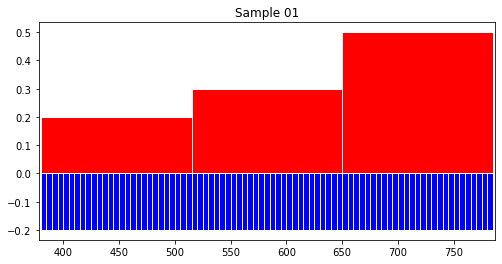

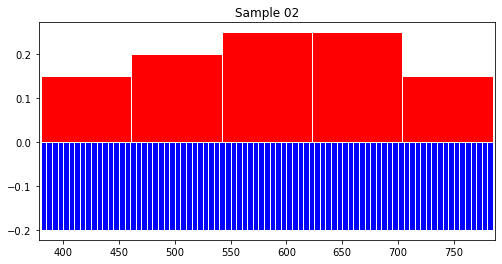

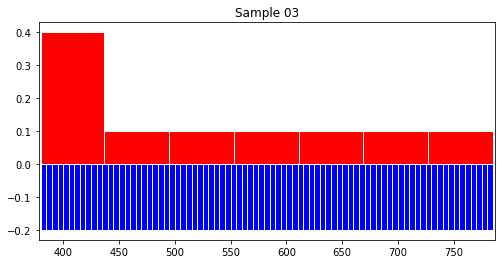

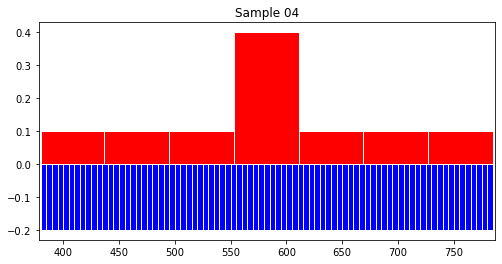

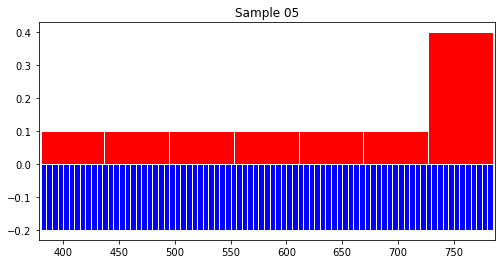

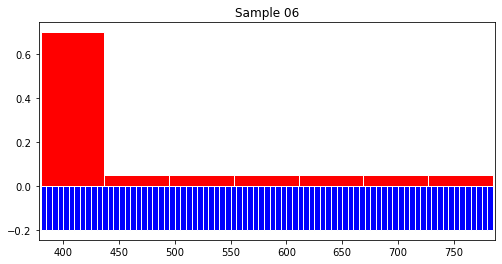

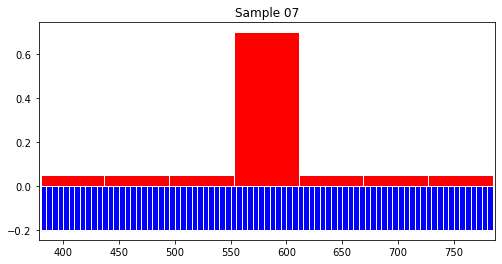

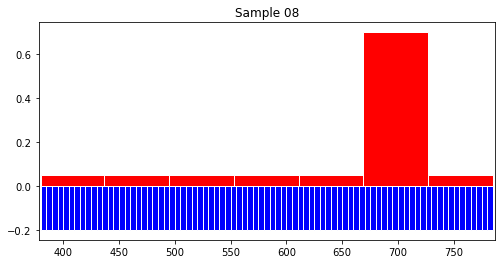

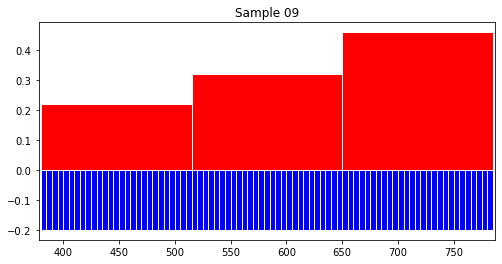

In [5]:
cycle = [('Sample 01', li_01), ('Sample 07', li_07)]
for title, li_eval in my_dict.items():
    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(121)
    ax.plot()
    start = li_range[0]
    for end in li_range[1:]:
        ax.add_patch(Rectangle((start, 0), end-start, -0.2, facecolor='blue', edgecolor='white'))
        start = end
    li_sample = np.linspace(min_opt, max_opt, len(li_eval) + 1, dtype=int)
    start = li_sample[0]
    for end, amp in zip(li_sample[1:], li_eval):
        ax.add_patch(Rectangle((start, 0), end-start, amp, facecolor='red', edgecolor='white'))
        start = end
    plt.xlim([li_range[0]-2, li_range[-1]+2])
    plt.title('Sample ' + title)
    plt.show()

### for each bucket in the evaluation space we need to map the "average height" in the sample space

In [6]:
li_pro = []
li_lvl = []
li_srt = []
li_end = []
for label, my_li in my_dict.items():
    intervals = np.linspace(min_opt, max_opt, len(my_li) + 1, dtype=int)
    for i in range(len(my_li)):
        li_pro.append(label)
        li_lvl.append(my_li[i])
        li_srt.append(intervals[i])
        li_end.append(intervals[i+1])

In [7]:
data = {'profile': li_pro, 'lvl': li_lvl, 'start': li_srt, 'end': li_end}
df = pd.DataFrame(data=data)

In [8]:
df.head(5)

profile   lvl  start  end
0      01  0.20    380  515
1      01  0.30    515  650
2      01  0.50    650  785
3      02  0.15    380  461
4      02  0.20    461  542

In [9]:
det_pro = []
det_lvl = []
det_srt = []
det_end = []
det_range = li_range[:-1]

for profile in my_dict.keys():
    for start in det_range:
        end = start + stp_opt
        det_pro.append(profile)
        df_tmp = df.loc[(df['profile'] == profile) & (df['start'] <= end) & (df['end'] > start)]
        if df_tmp.shape[0] > 1:
            cnt = 0
            lvl_sum = 0
            for s in range(start, end):
                cnt += 1
                lvl_sum += df_tmp.loc[(df_tmp['start'] <= s+1) & (df_tmp['end'] > s), ['lvl']].values[0][0]
            det_lvl.append(lvl_sum / cnt)
        else:
            det_lvl.append(df_tmp['lvl'].values[0])
        det_srt.append(start)
        det_end.append(end)

In [10]:
data = {'profile': det_pro, 'lvl': det_lvl, 'start': det_srt, 'end': det_end}
df_det = pd.DataFrame(data=data)

In [11]:
df_det.head(5)

profile  lvl  start  end
0      01  0.2    380  385
1      01  0.2    385  390
2      01  0.2    390  395
3      01  0.2    395  400
4      01  0.2    400  405

## to visualize:

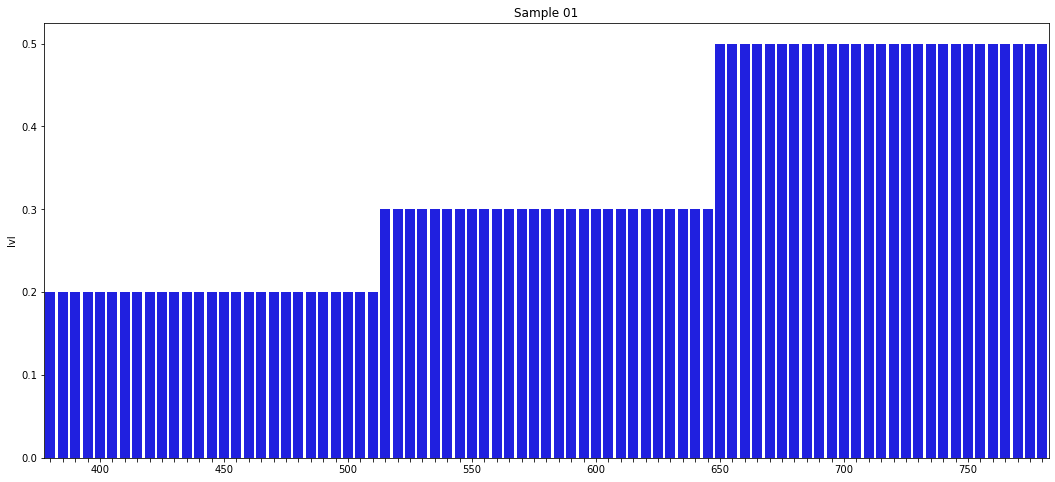

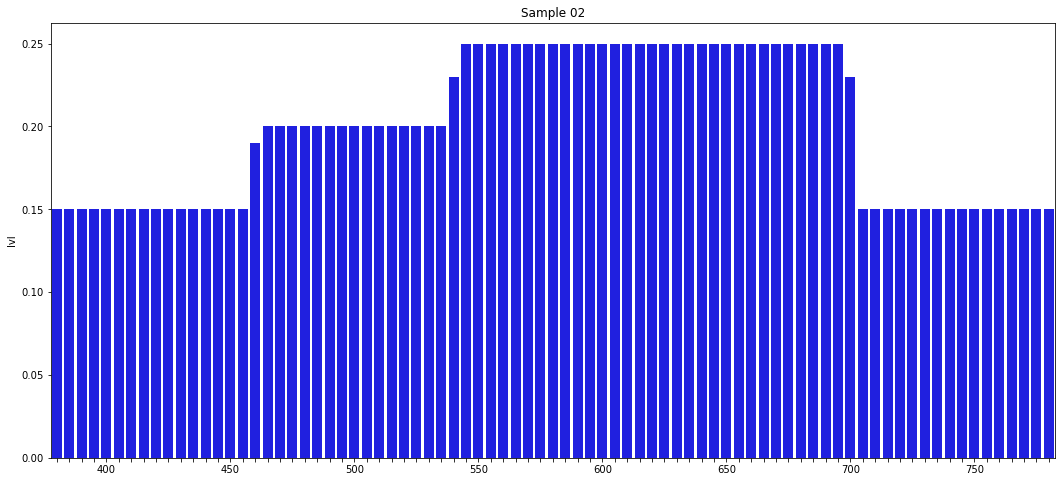

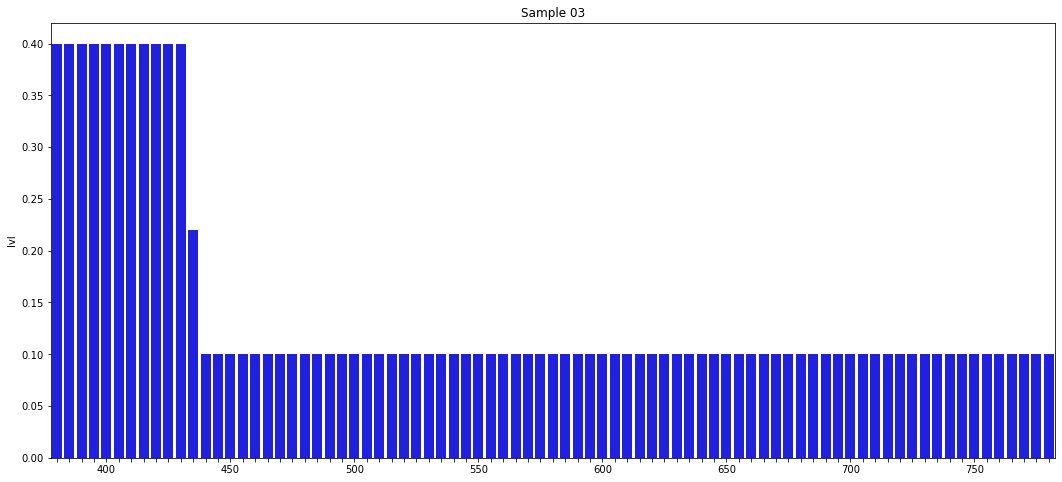

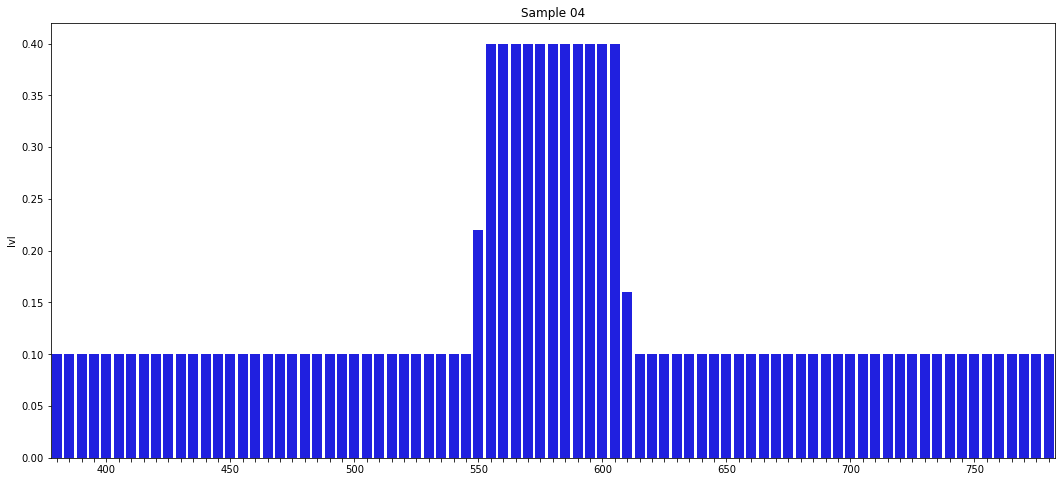

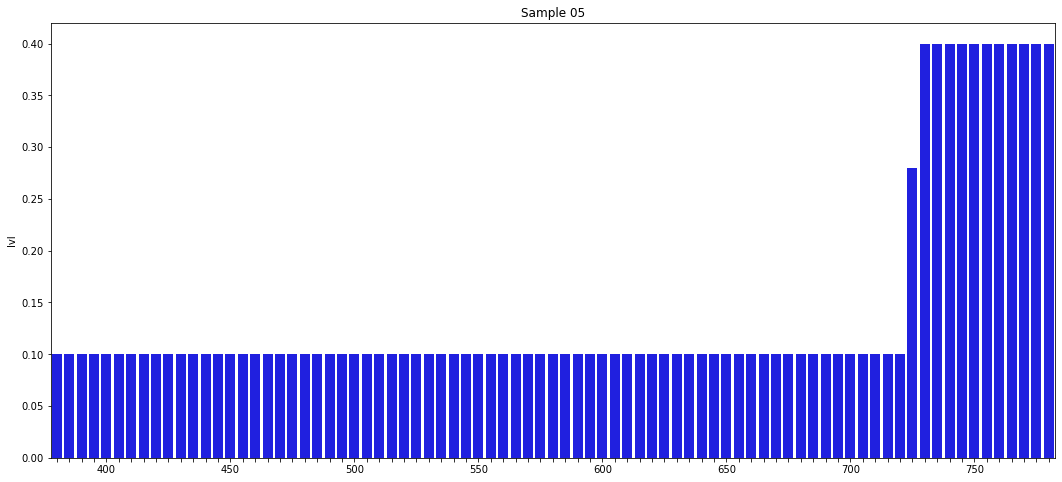

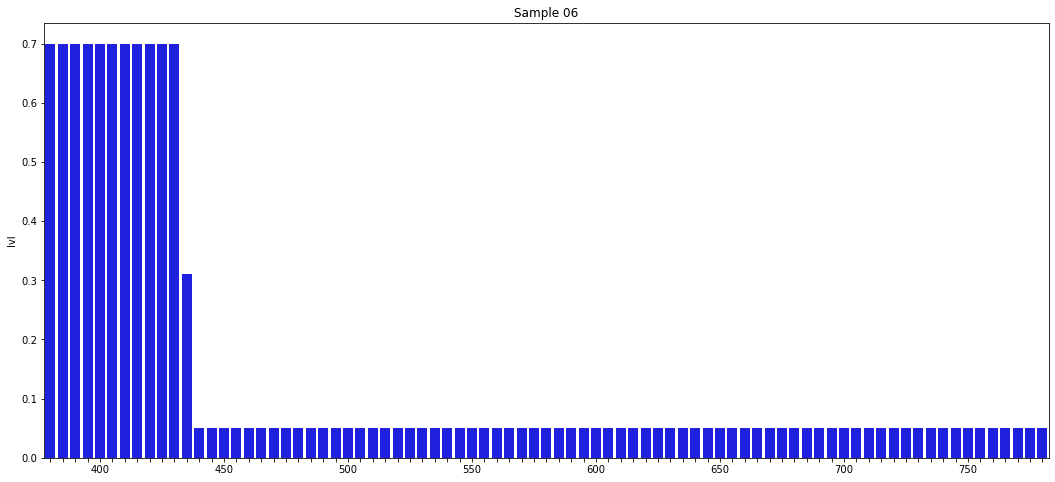

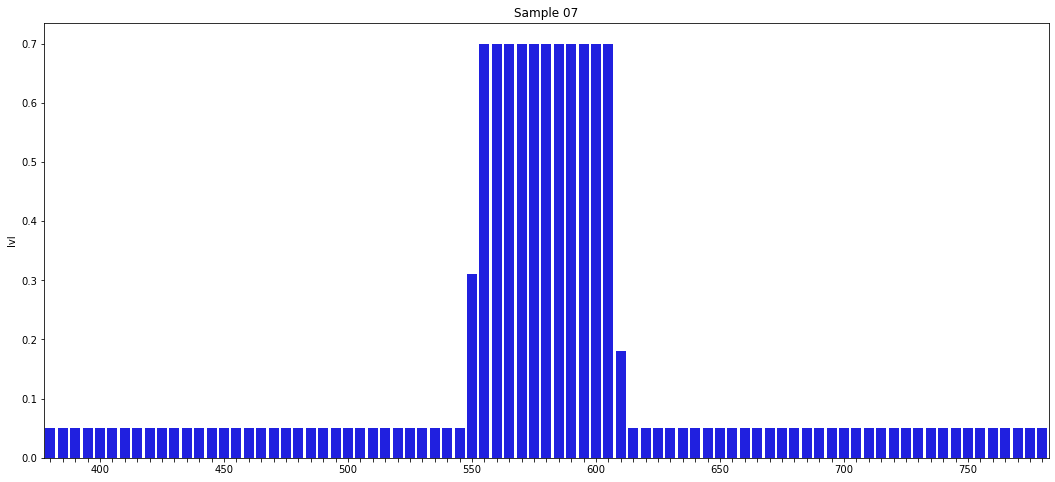

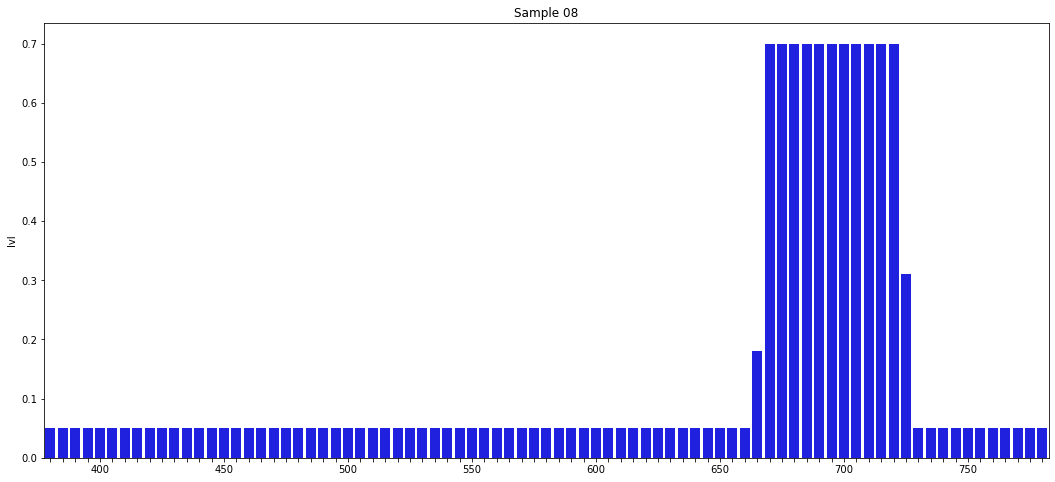

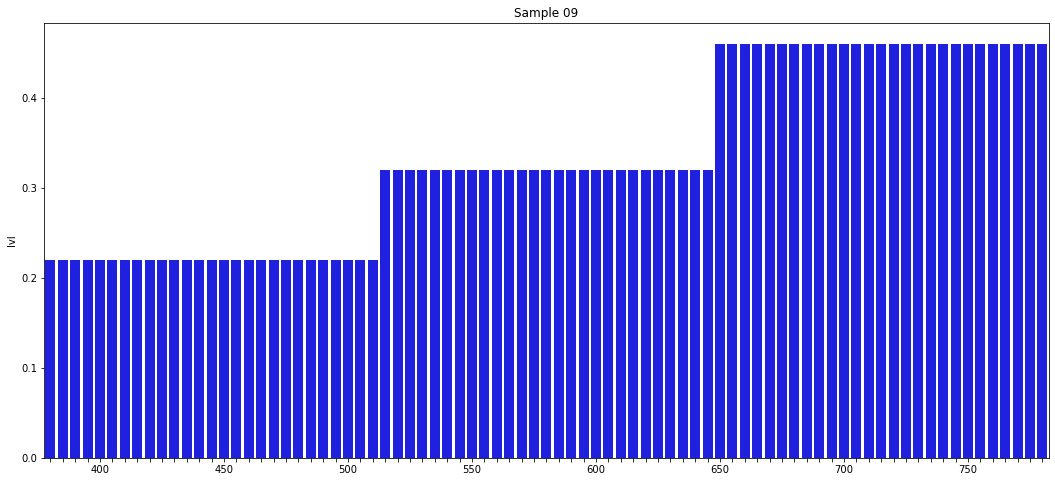

In [12]:
for smpl in list(df_det.profile.unique()):
    plt.figure(figsize=(18,8))
    ax = sns.barplot(x='start', y='lvl', data=df_det[df_det.profile == smpl], color='blue')
    ax.set(title='Sample ' + smpl)
    ax.set(xlabel=None)
    ax.set(xticklabels=[j if j % 50 == 0 else '' for j in li_range[:-1]])
    plt.show()

As can be seen in above plots, in the areas of transition from one to the next box in the sample space, the average is taken which creates the one in-between height bar (where applicable)

### Generating color
as next step, we now can generate a color out of this distribution.  
At the same time we generate the x-y coordiantes in the color

In [13]:
profil = []
colors = []
x_cord = []
y_cord = []
for profile in df_det.profile.unique():
    spec = np.array(df_det.loc[df_det['profile'] == profile, ['lvl']]['lvl'].tolist())
    html = cs.spec_to_rgb(spec, out_fmt='html')
    x, y = cs.sepc_to_xy(spec)
    profil.append(profile)
    colors.append(html)
    x_cord.append(x)
    y_cord.append(y)
    print('{}: {} (x: {}, y: {})'.format(profile, html, x, y))

01: #ffb97d (x: 0.37434302290145177, y: 0.3673007716288065)
02: #ffbf84 (x: 0.36888526060559196, y: 0.36559571670225577)
03: #b484ff (x: 0.29416513398777, y: 0.25873592113918176)
04: #ff9941 (x: 0.42439315919819365, y: 0.3989655832802561)
05: #ffd6ce (x: 0.3333971961614215, y: 0.3333225249574572)
06: #5223ff (x: 0.23865977878059855, y: 0.1529236493374138)
07: #ff840e (x: 0.48703303296223377, y: 0.444094362970969)
08: #ffa4a4 (x: 0.3603236465891916, y: 0.32964642483720175)
09: #ffbd83 (x: 0.36990655533339944, y: 0.3652244836477712)


In [14]:
data = {'profile': profil, 'color': colors, 'x_cord': x_cord, 'y_cord': y_cord}
df_col = pd.DataFrame(data=data)

In [15]:
df_col

profile    color    x_cord    y_cord
0      01  #ffb97d  0.374343  0.367301
1      02  #ffbf84  0.368885  0.365596
2      03  #b484ff  0.294165  0.258736
3      04  #ff9941  0.424393  0.398966
4      05  #ffd6ce  0.333397  0.333323
5      06  #5223ff  0.238660  0.152924
6      07  #ff840e  0.487033  0.444094
7      08  #ffa4a4  0.360324  0.329646
8      09  #ffbd83  0.369907  0.365224

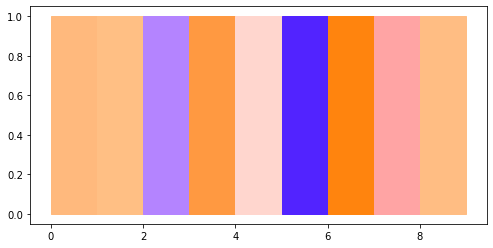

In [16]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
ax.plot()
start = 0
colors = df_col.color.to_list()
for color in colors:
    ax.add_patch(Rectangle((start, 0), 1, 1,color=color))
    start += 1
plt.show()

## plotting the distribution on the CIE plot

[(0.0, 1.0), (0.0, 1.0)]

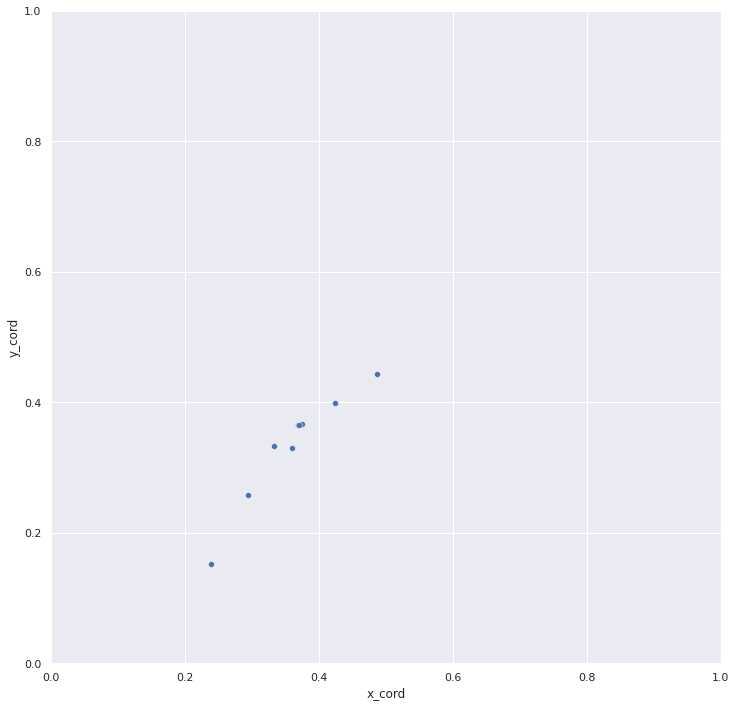

In [17]:
sns.set(rc = {'figure.figsize':(12,12)})
scatter_dist = sns.scatterplot(data=df_col, x='x_cord', y='y_cord')
scatter_dist.set(xlim=(0,1), ylim=(0,1))

## using the color codes for clustering
now that we have seen the principle application to grouping / comparing different relative distributions, let's have a look at a larger dataset and see if we can do actual clustering


In [18]:
df_col = pd.read_csv('data/cluster_by_color_example.csv')

In [19]:
df_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512126 entries, 0 to 512125
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   location    512126 non-null  object 
 1   department  512126 non-null  object 
 2   art_nr      512126 non-null  int64  
 3   quantity    512126 non-null  int64  
 4   rel_dist    512126 non-null  object 
 5   html        512126 non-null  object 
 6   x_cord      512126 non-null  float64
 7   y_cord      512126 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 31.3+ MB


In [20]:
df_col.describe()

art_nr       quantity         x_cord         y_cord
count  5.121260e+05  512126.000000  512126.000000  512126.000000
mean   7.100288e+08      12.320068       0.380958       0.369298
std    1.030595e+08      20.023836       0.157128       0.126624
min    1.001460e+08       1.000000       0.006333       0.017829
25%    7.051550e+08       2.000000       0.279525       0.298624
50%    7.379450e+08       7.000000       0.365800       0.372758
75%    7.644520e+08      14.000000       0.461026       0.440324
max    9.780070e+08    1184.000000       0.721014       0.813393

In [21]:
col_all = list(df_col.columns)
col_num = list(df_col.select_dtypes([np.number]).columns)
col_cat = ['department', 'art_nr']
col_otr = [col for col in col_all if col not in col_num + col_cat]

In [22]:
for col in col_all:
    print('column {:>10} has {:>6} unique values'.format(col, len(df_col[col].unique())))

column   location has    103 unique values
column department has      9 unique values
column     art_nr has  11519 unique values
column   quantity has    432 unique values
column   rel_dist has 201286 unique values
column       html has  94678 unique values
column     x_cord has 199787 unique values
column     y_cord has 199922 unique values


This data example has a bit more than 0.5M rows, distributed across 103 locations, 9 departments and 11519 individual article numbers.  
**Note:** This is actual data preprocessed and anonymized prior to using it available here. The preparation is some data cleaning and transformation to generate the relative distributions for each art_nr and based on this the color code and x-y coordinates.  
The incomming dataset ahd aprox. 2.1M rows, hence we have an average of 4 rel. distributed, ordered items within each art_nr. (no one item art_nrs are in this dataset)

In [23]:
df_col['x_weight'] = df_col.x_cord * df_col.quantity
df_col['y_weight'] = df_col.y_cord * df_col.quantity

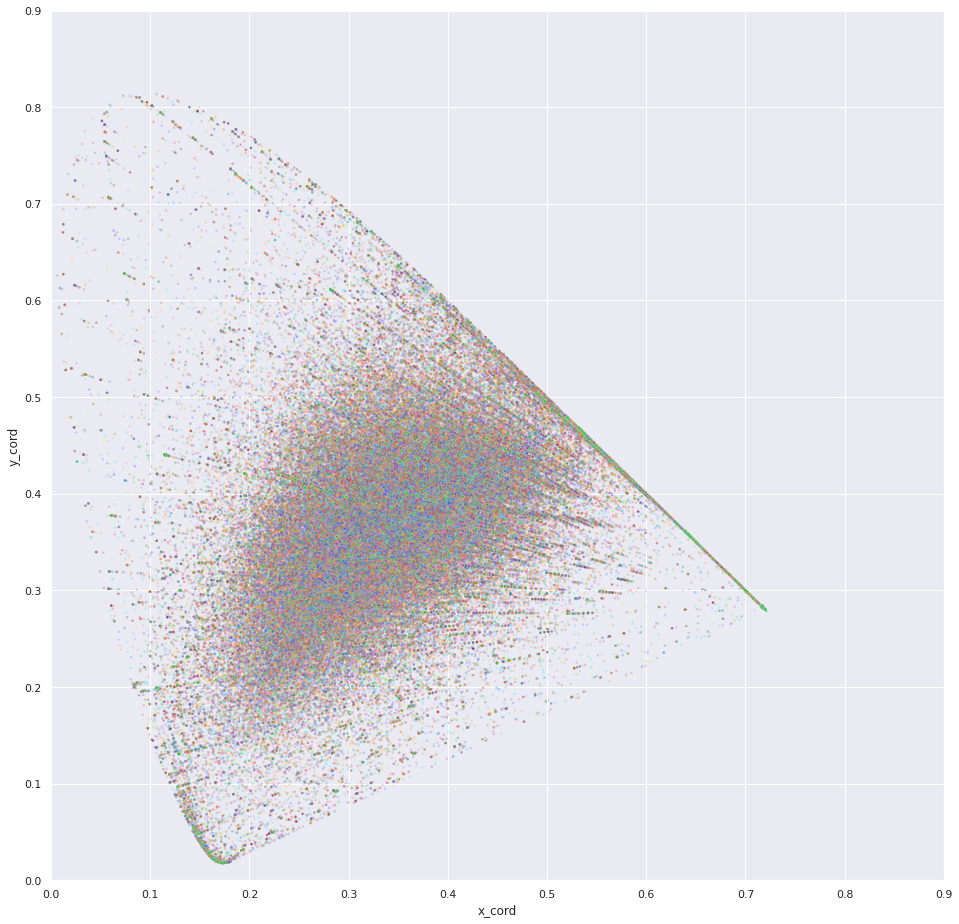

In [24]:
scatter(df_col, 'location', s=6, legend=False)

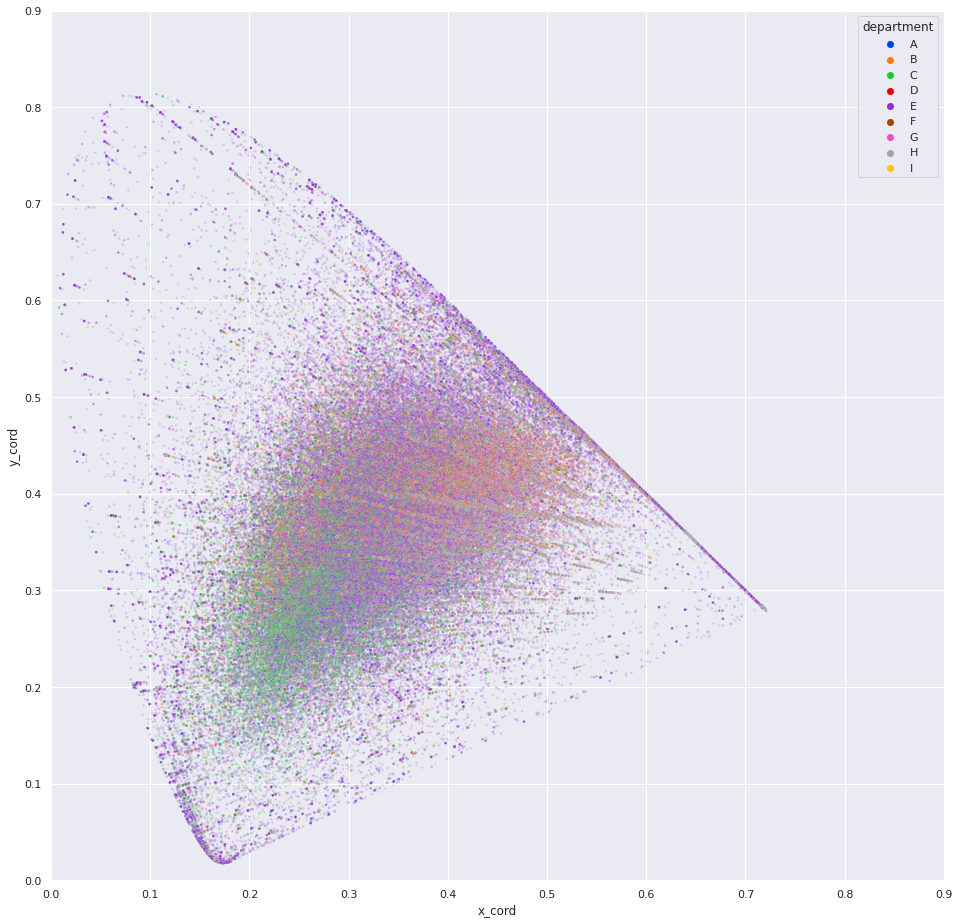

In [25]:
scatter(df_col, 'department', s=6)

It appears that there is some clustering happening when grouping by department.

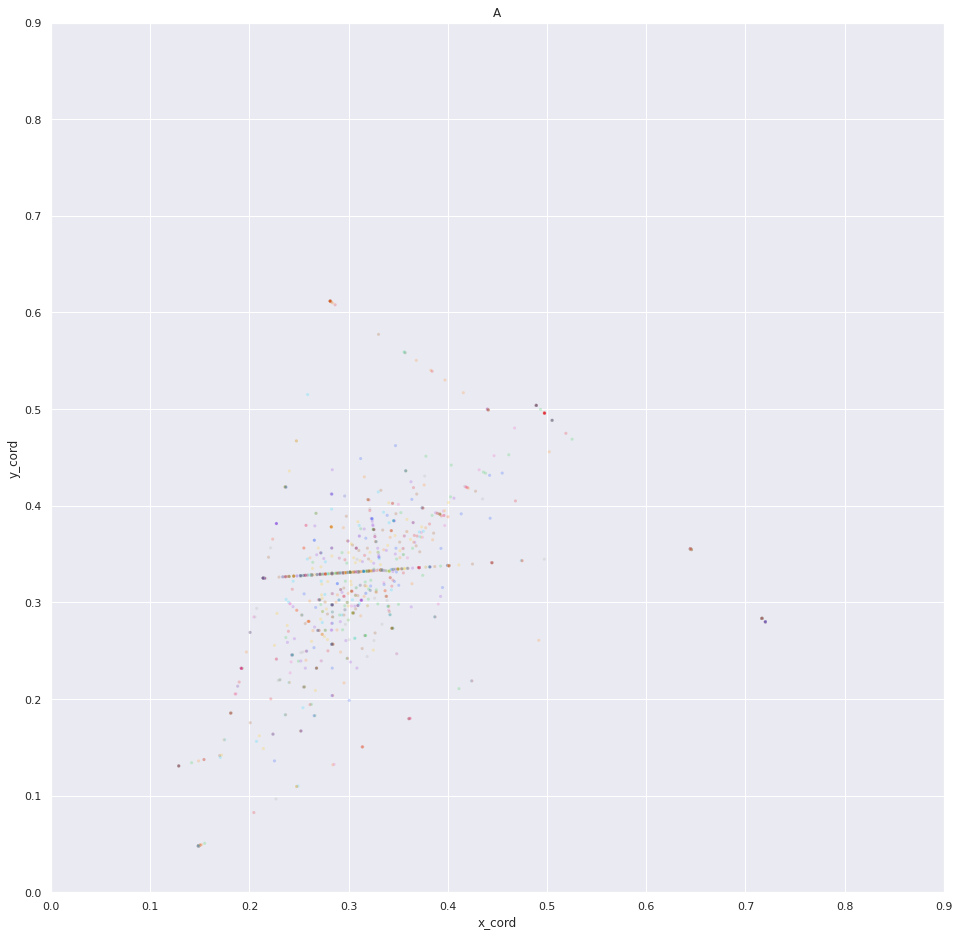

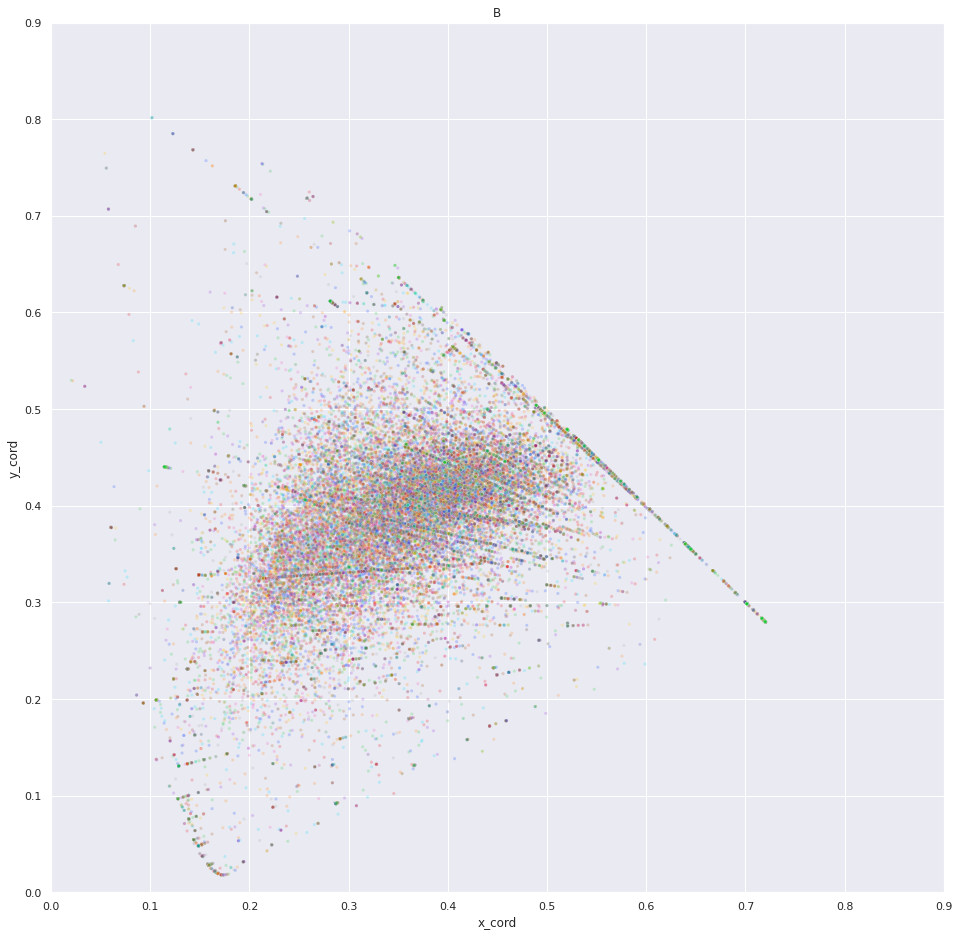

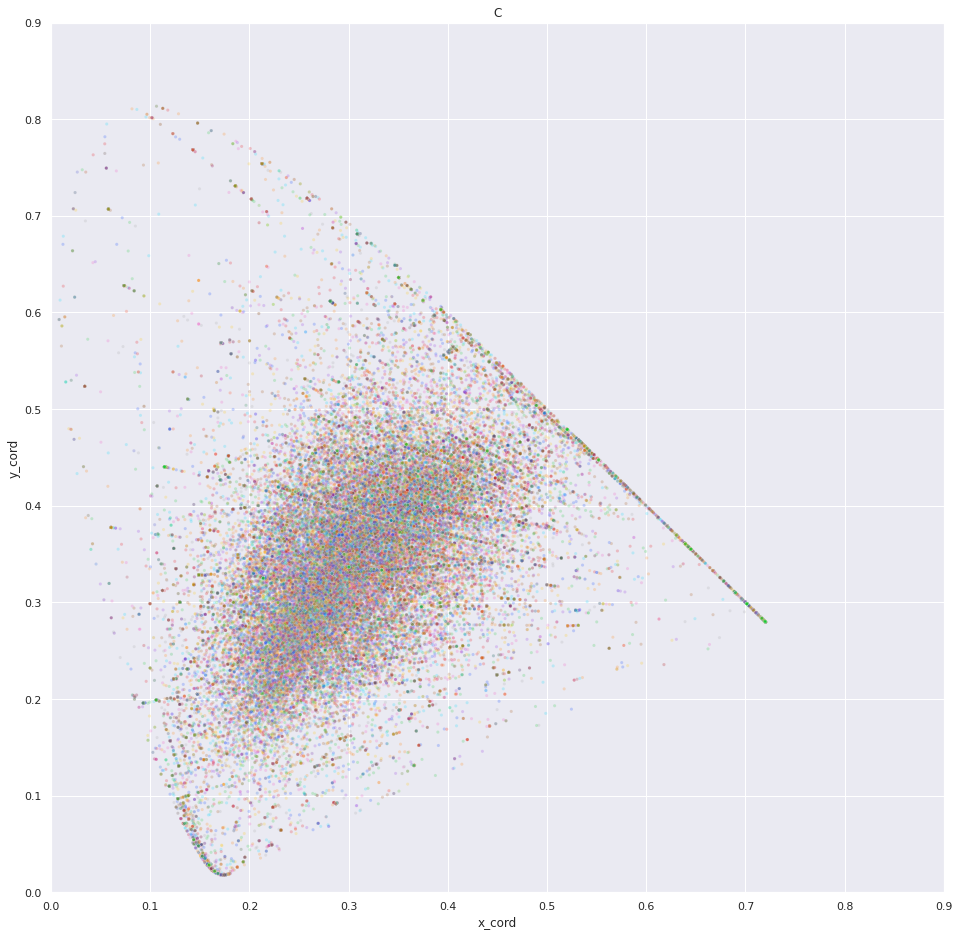

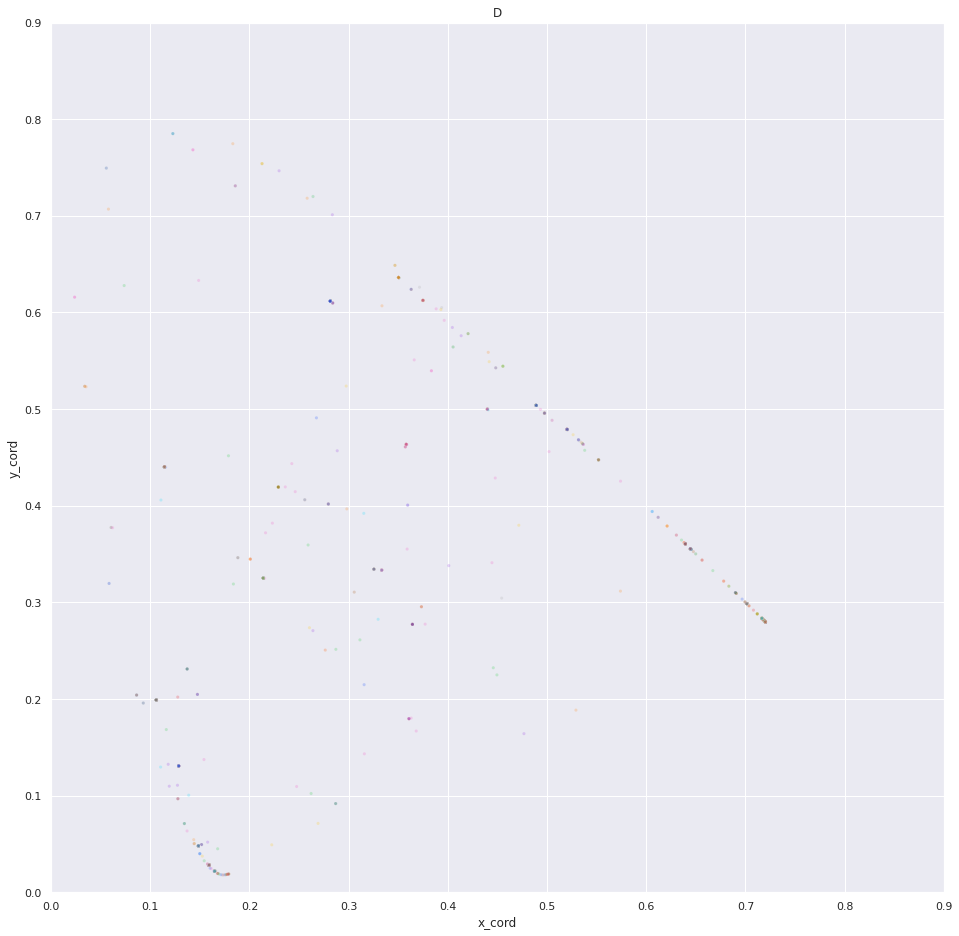

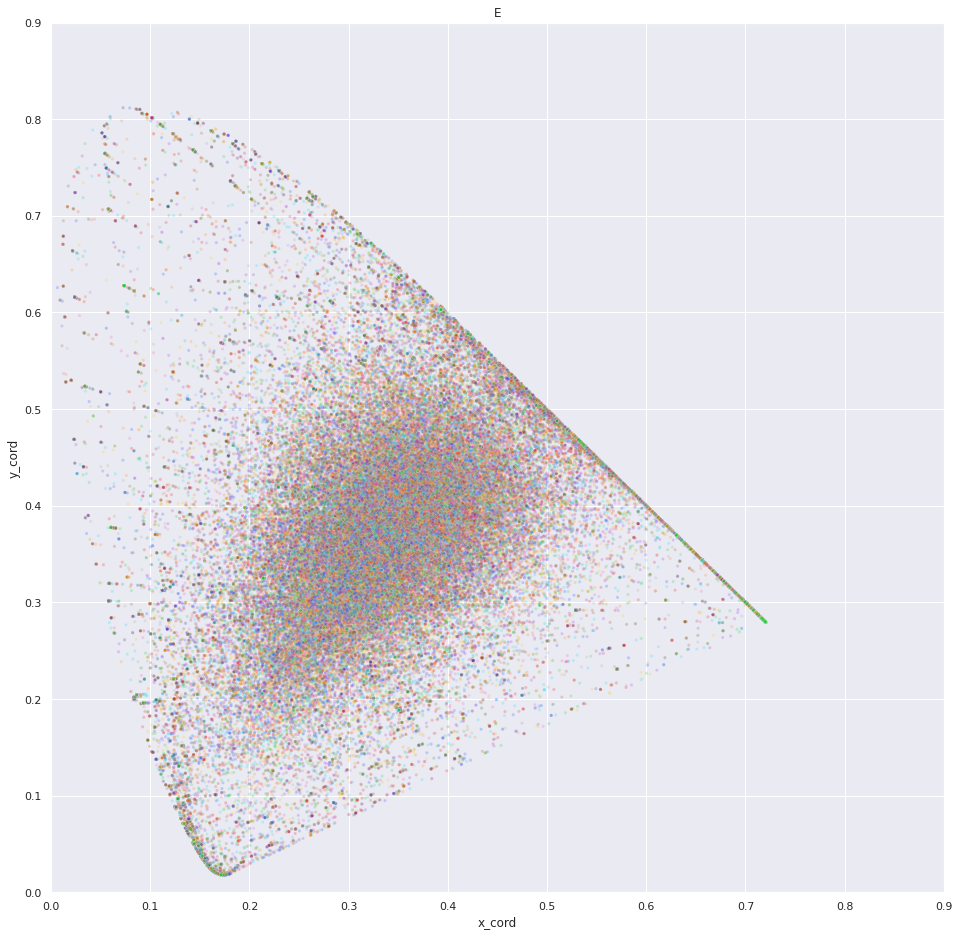

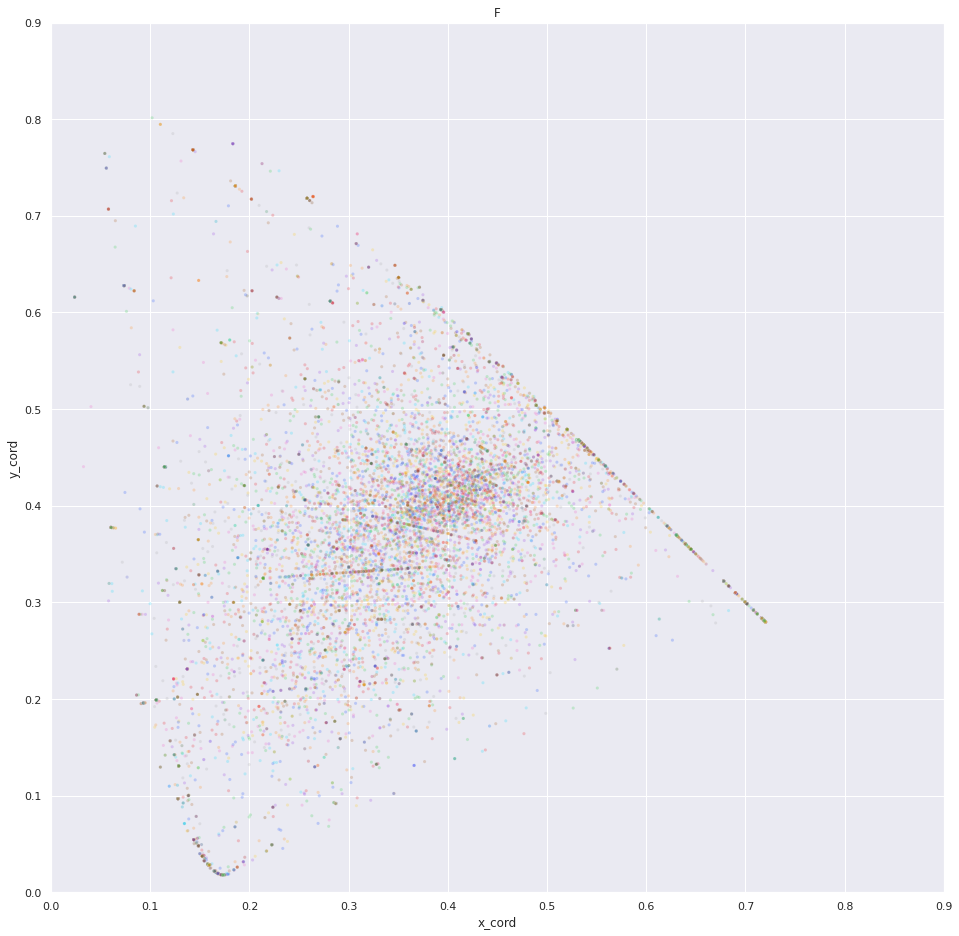

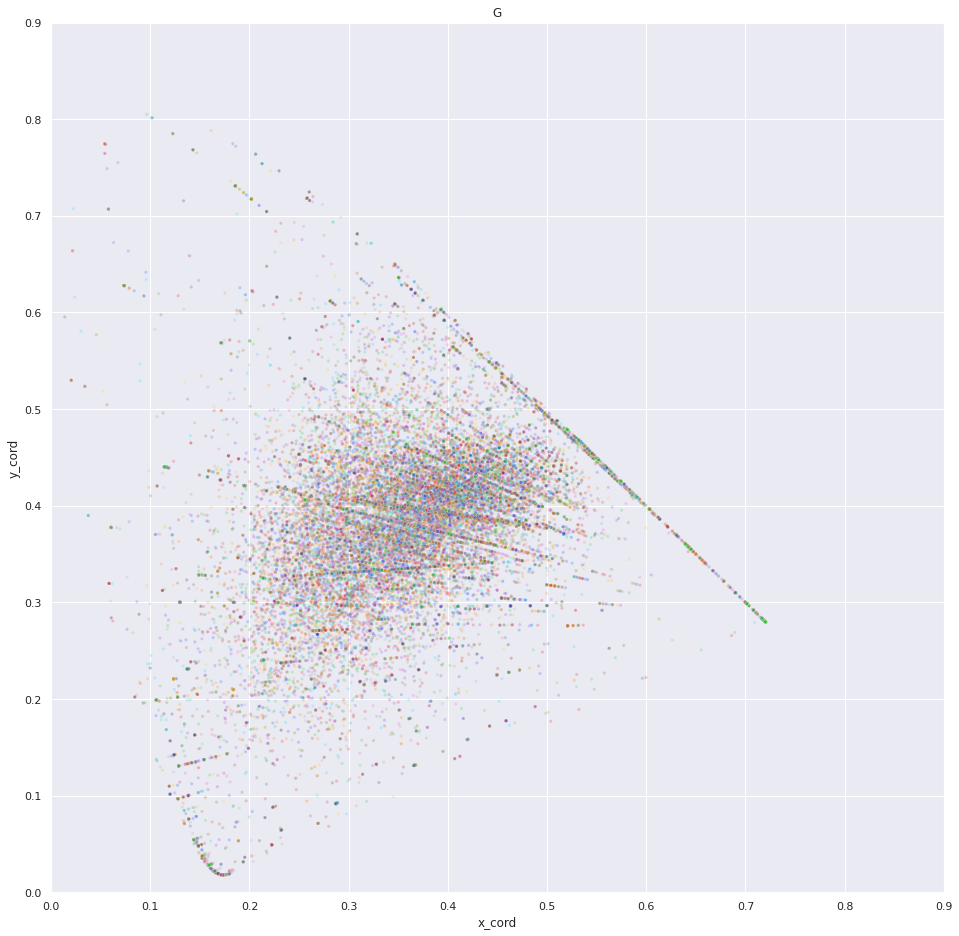

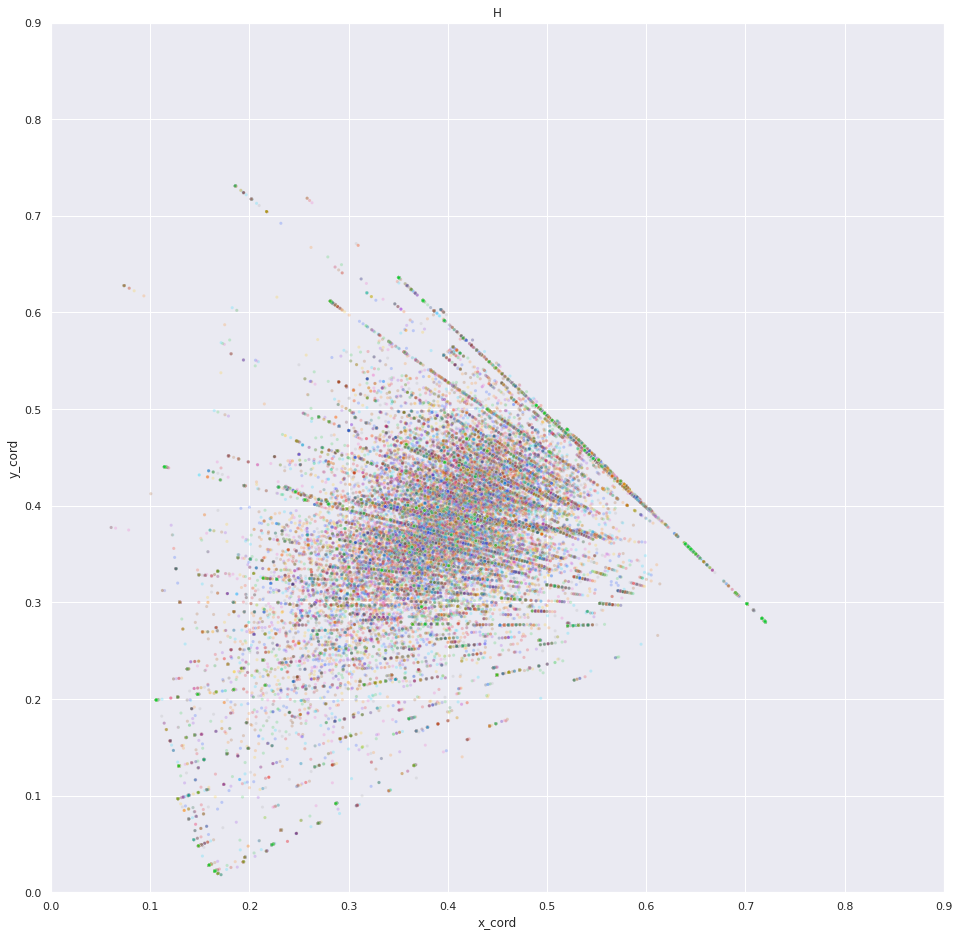

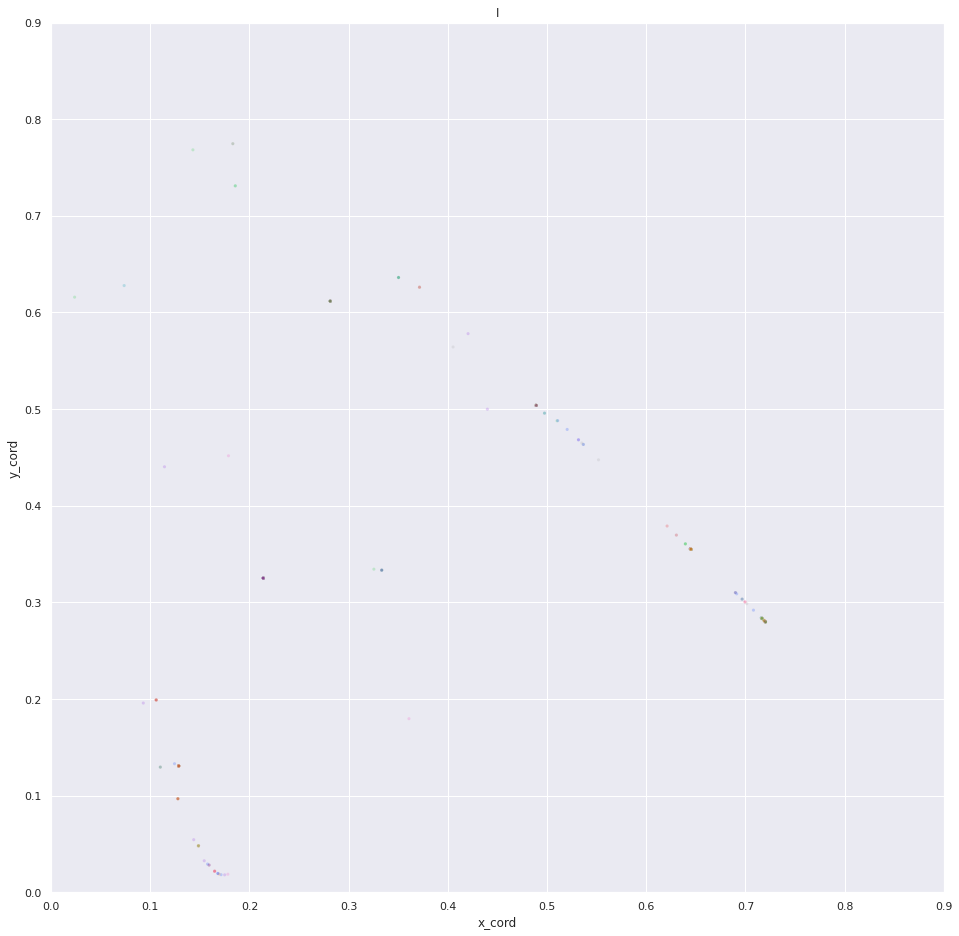

In [26]:
for dep in list(df_col.department.unique()):
    scatter(df_col[df_col.department == dep], 'location', title=dep, legend=False)

Now that we have the obvious out of the way, let's look at groupings:  
For this let's add an x_weight and y_weight column to our data so we can (if we want to) use the weight of a point based on quantity:

## group by Location and Department

In [27]:
li_grp = ['location', 'department']
di_agg = {'quantity': 'sum', 'x_weight': 'sum', 'y_weight': 'sum'}
df_grp_loc_dept = df_col.groupby(li_grp).agg(di_agg).reset_index()
df = df_grp_loc_dept
df['x_group'] = df.x_weight / df.quantity
df['y_group'] = df.y_weight / df.quantity

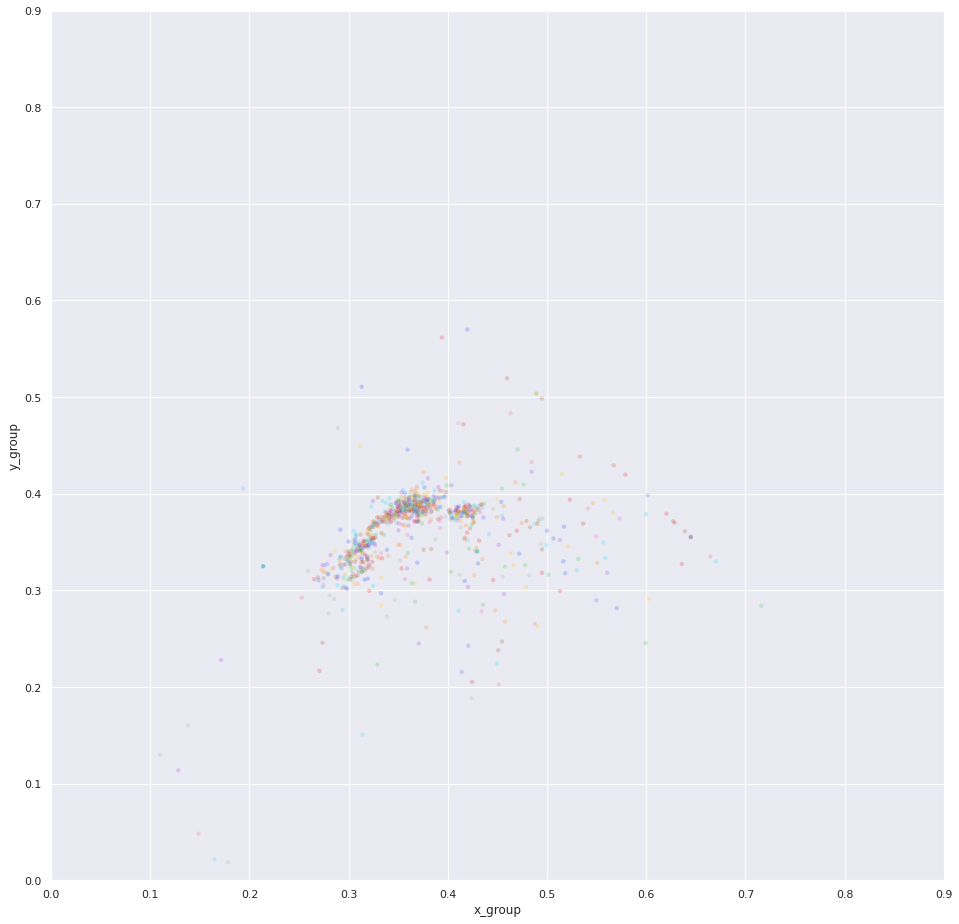

In [28]:
scatter(df, 'location', s=20, x_cord='x_group', y_cord='y_group', legend=False)

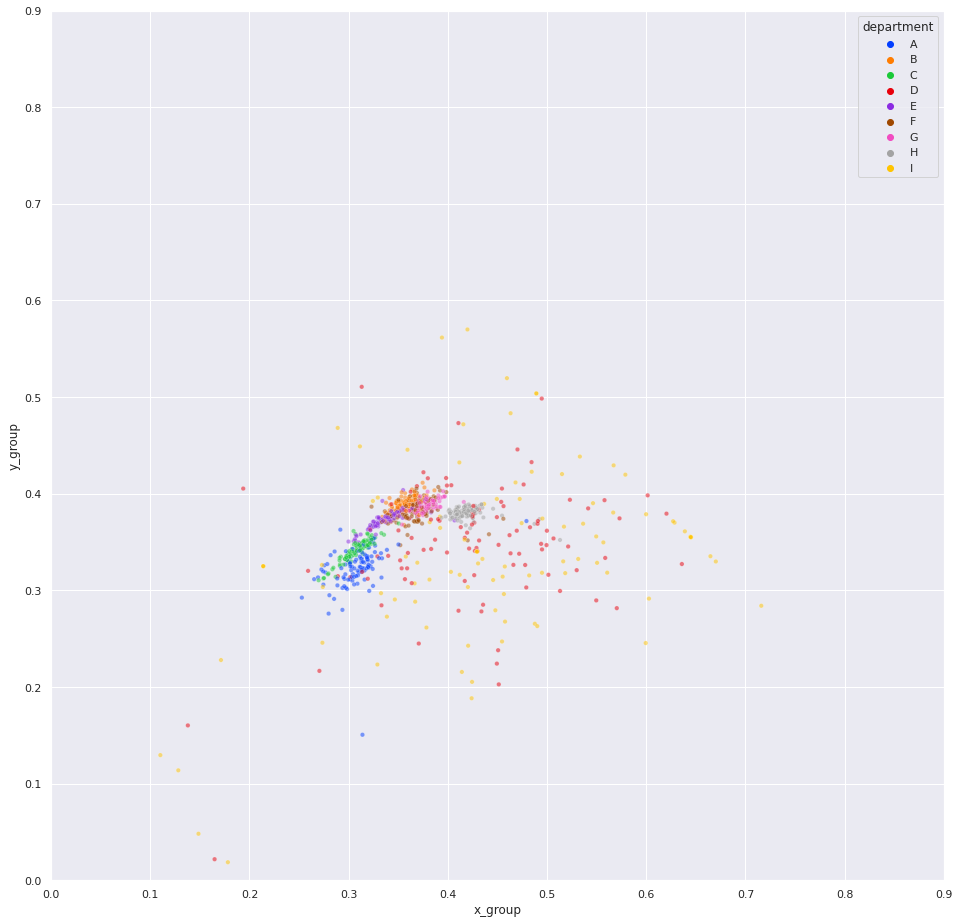

In [29]:
scatter(df, 'department', s=20, x_cord='x_group', y_cord='y_group', alpha=0.5)

Now this looks like a pattern emerging. Let's isolate:

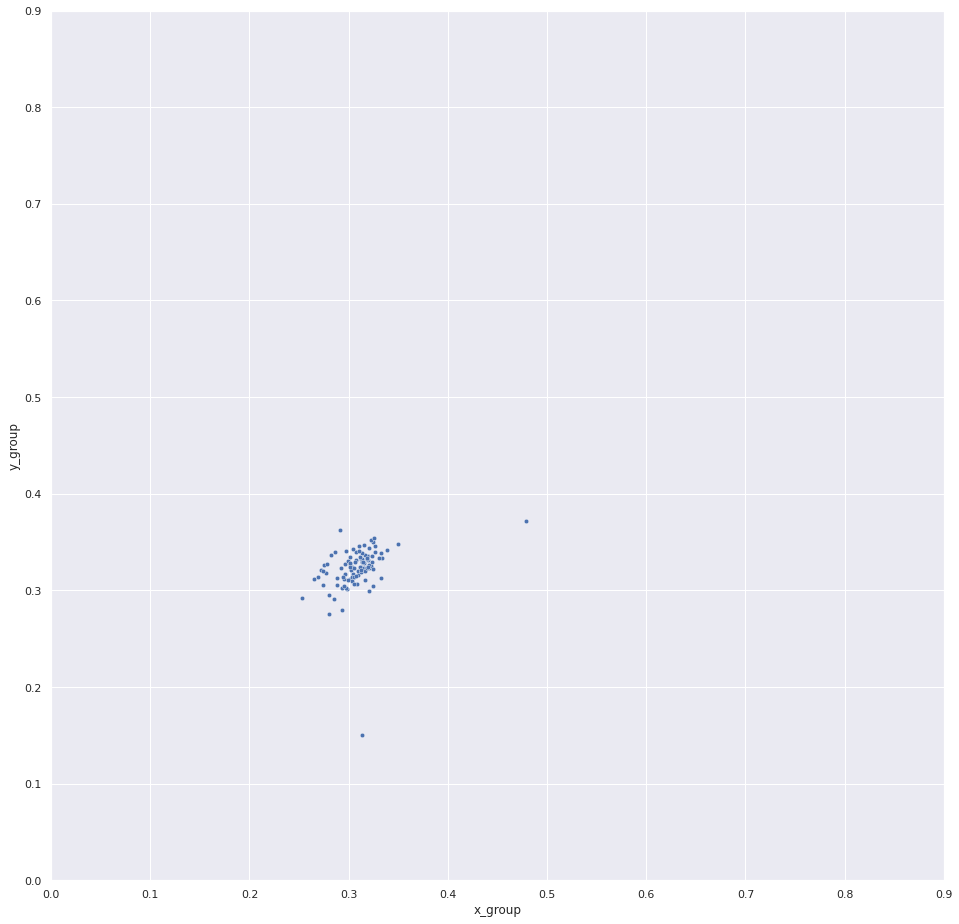

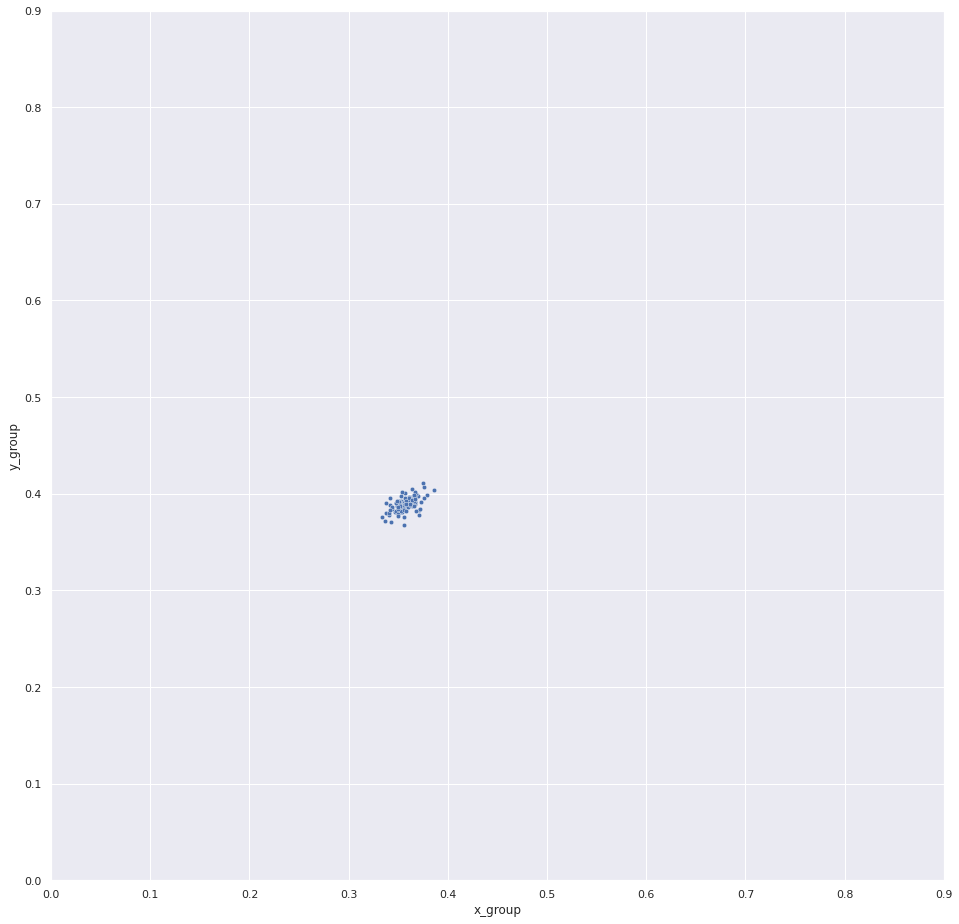

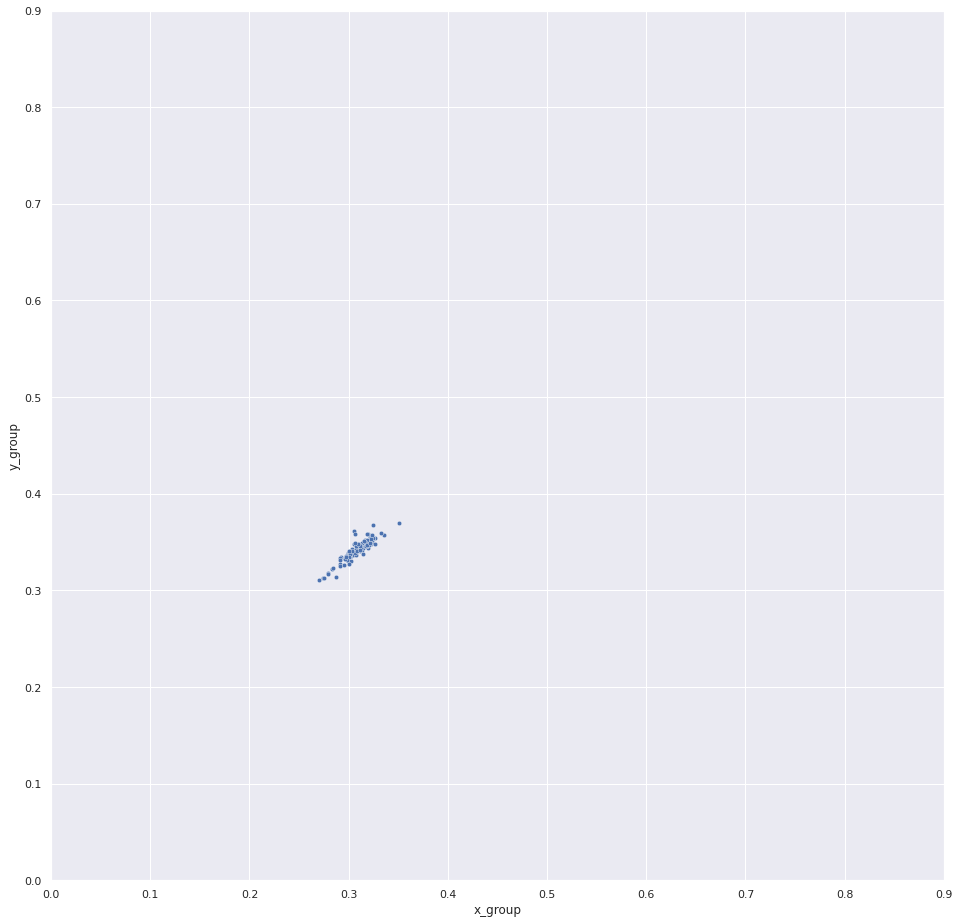

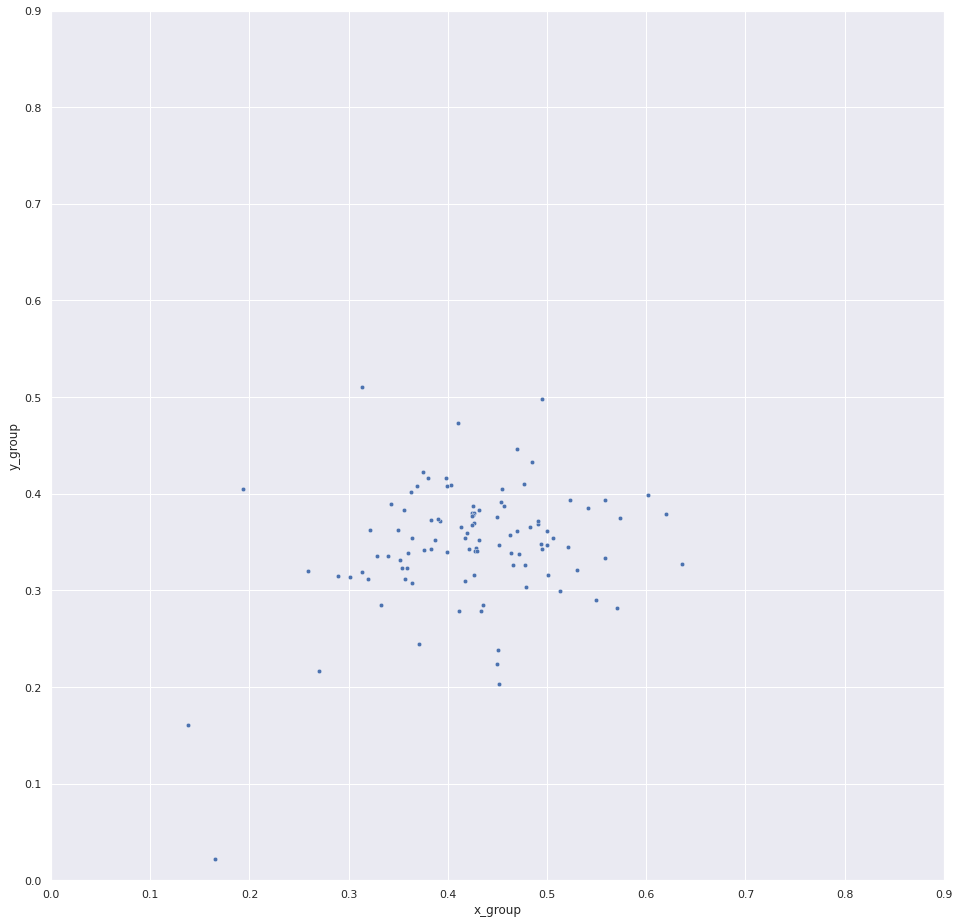

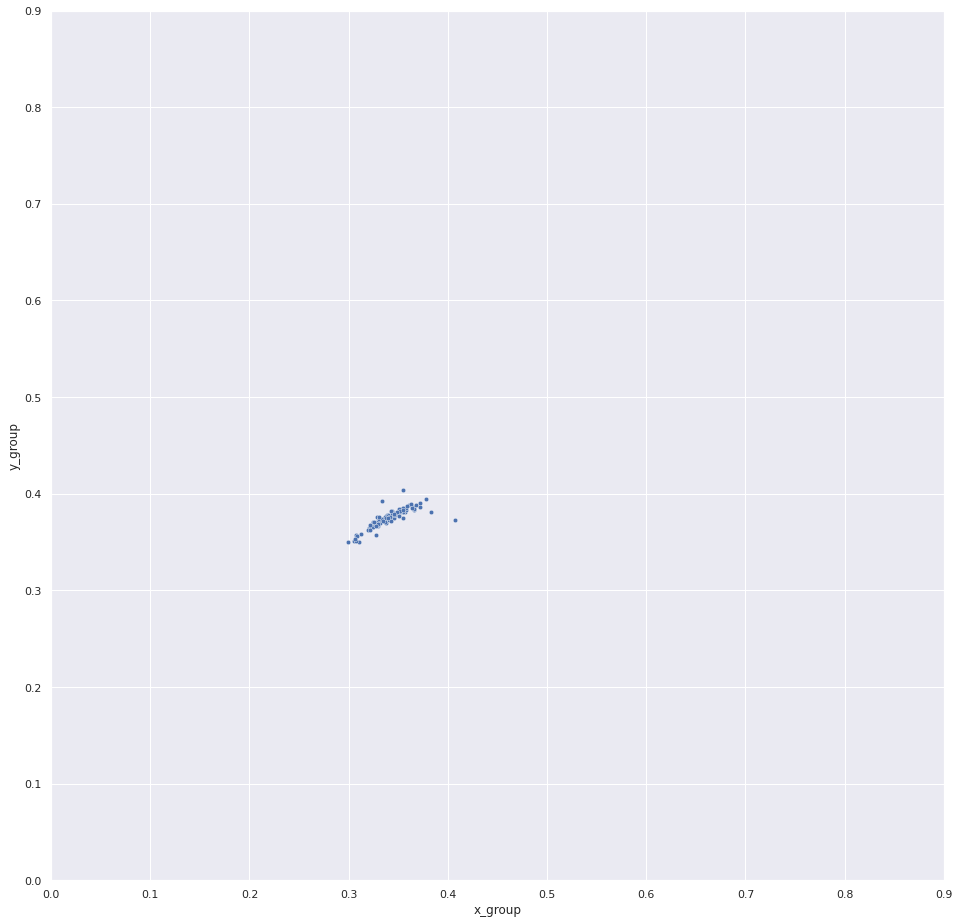

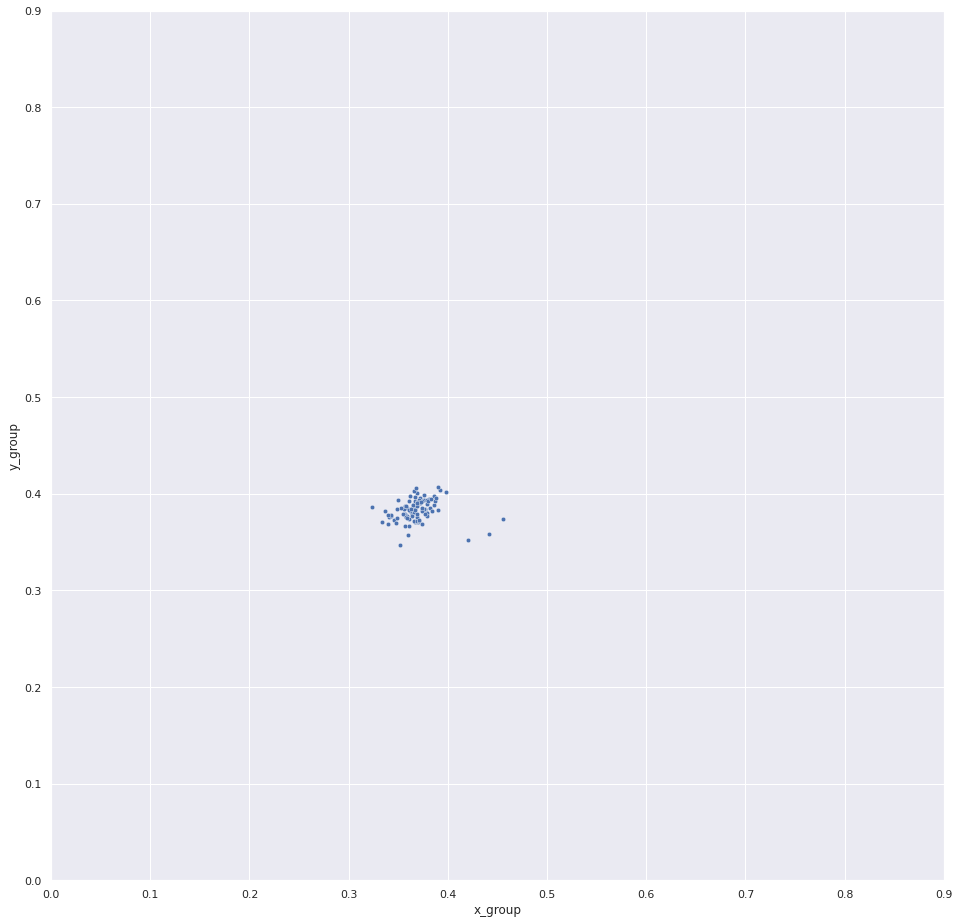

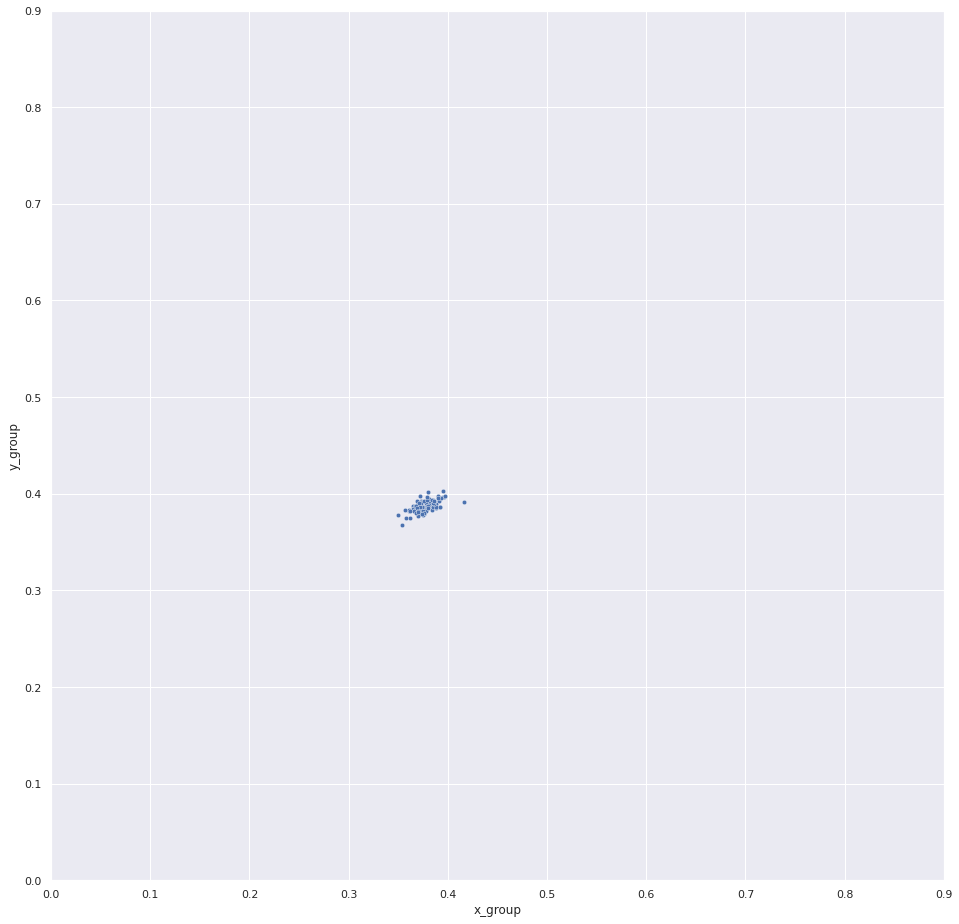

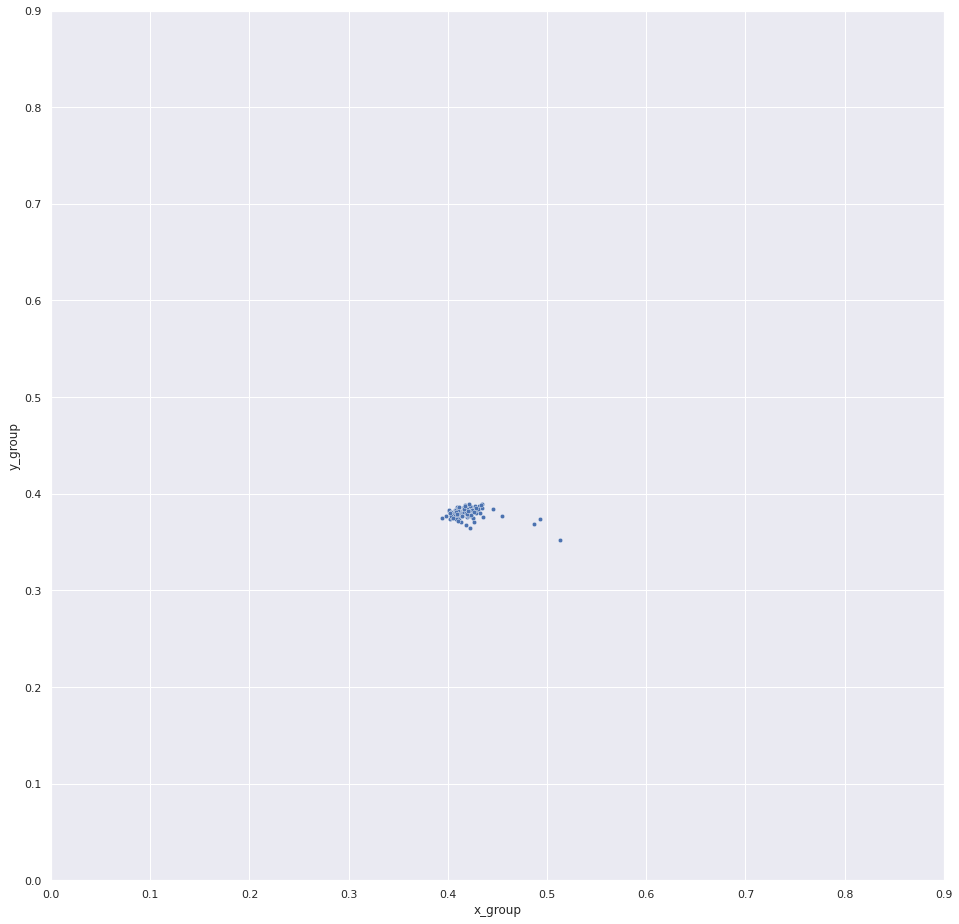

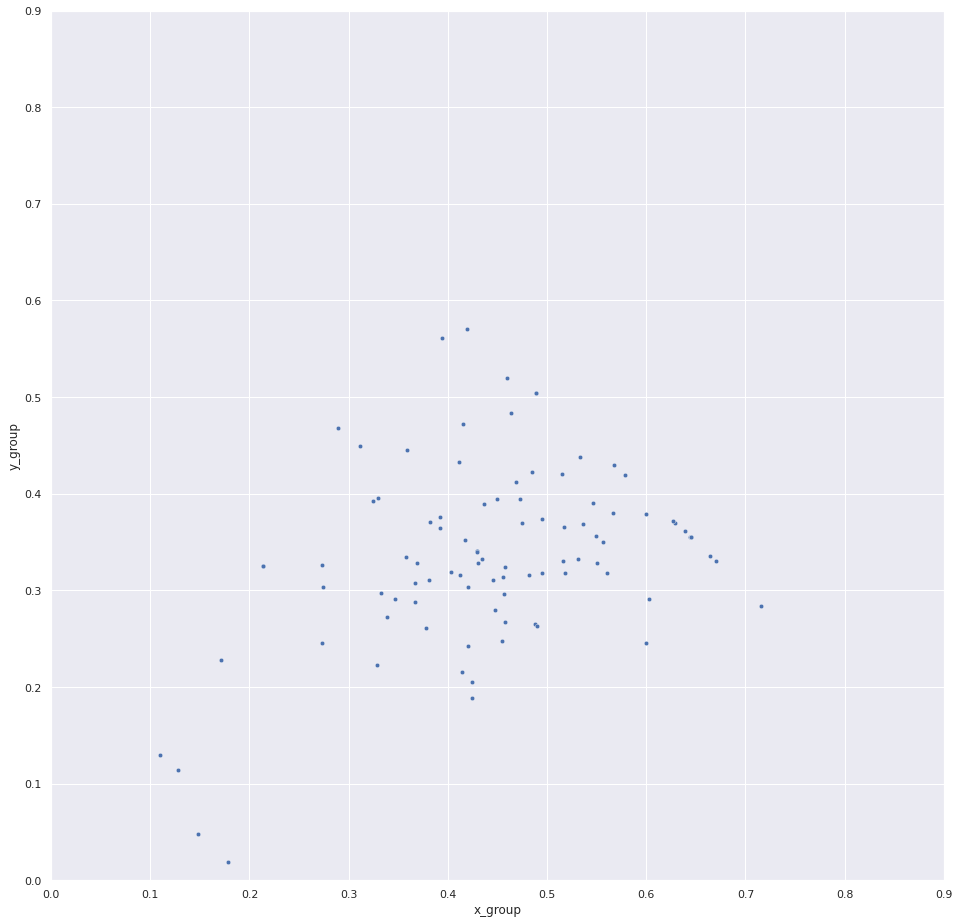

In [30]:
for dept in df.department.unique().tolist():
    scatter(df[df.department == dept], hue=None, x_cord='x_group', y_cord='y_group', s=20, alpha=1)

Some departmnets cluster nicely, while others are a bit distributed.
## so let's group by location only 


In [31]:
li_grp = ['location']
di_agg = {'quantity': 'sum', 'x_weight': 'sum', 'y_weight': 'sum'}
df_grp_loc = df_col.groupby(li_grp).agg(di_agg).reset_index()
df = df_grp_loc
df['x_group'] = df.x_weight / df.quantity
df['y_group'] = df.y_weight / df.quantity

Now let's produce a new "weighted" color code:

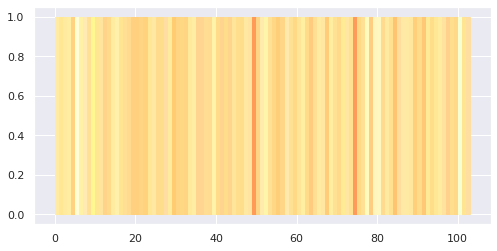

In [32]:
df['xyz'] = df.apply(lambda x: cs.xy_to_xyz(x.x_group, x.y_group), axis=1)
df['hex'] = df.apply(lambda x: cs.xyz_to_rgb(x.xyz, out_fmt='html'), axis=1)
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
ax.plot()
start = 0
colors = df.hex.to_list()
for color in colors:
    ax.add_patch(Rectangle((start, 0), 1, 1,color=color))
    start += 1
plt.show()

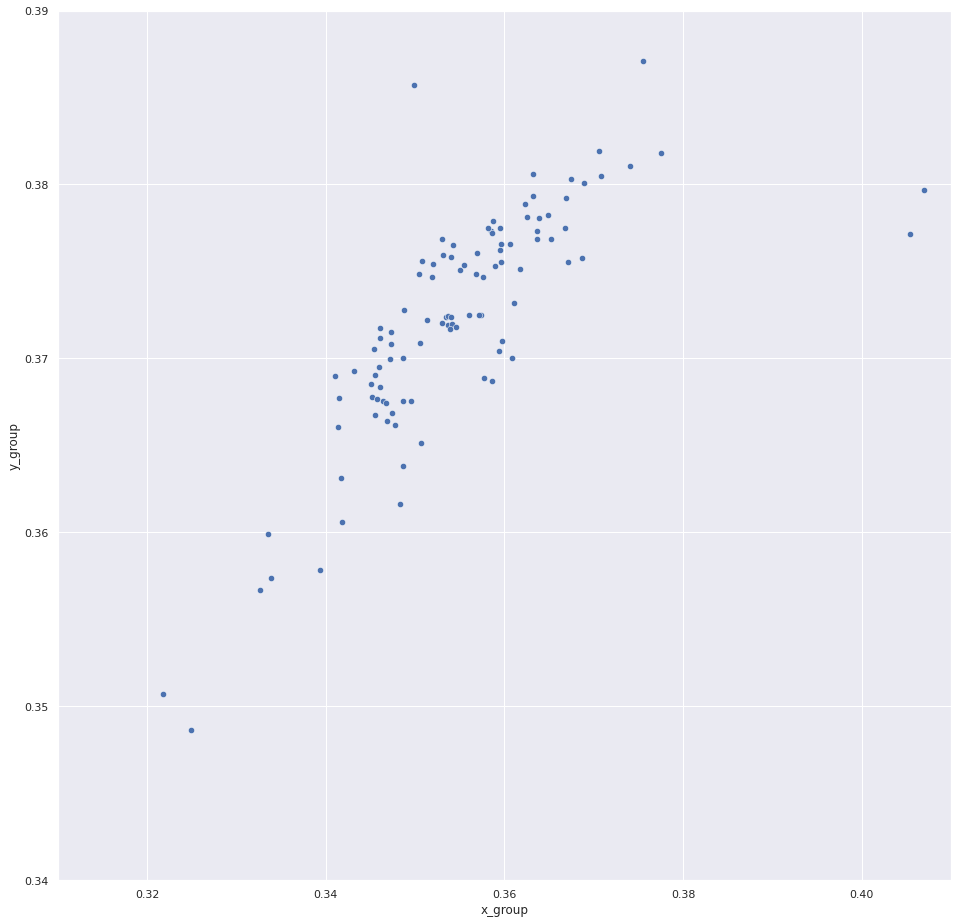

In [33]:
scatter(df, None, 'x_group', 'y_group', s=40, alpha=1, x_zoom=(0.31, 0.41), y_zoom=(0.34, 0.39))

In [34]:
from sklearn.mixture import GaussianMixture
X = df[['x_group', 'y_group']]
gm = GaussianMixture(n_components=7, random_state=0).fit(X)
gm.means_
df['cluster'] = gm.predict(X)

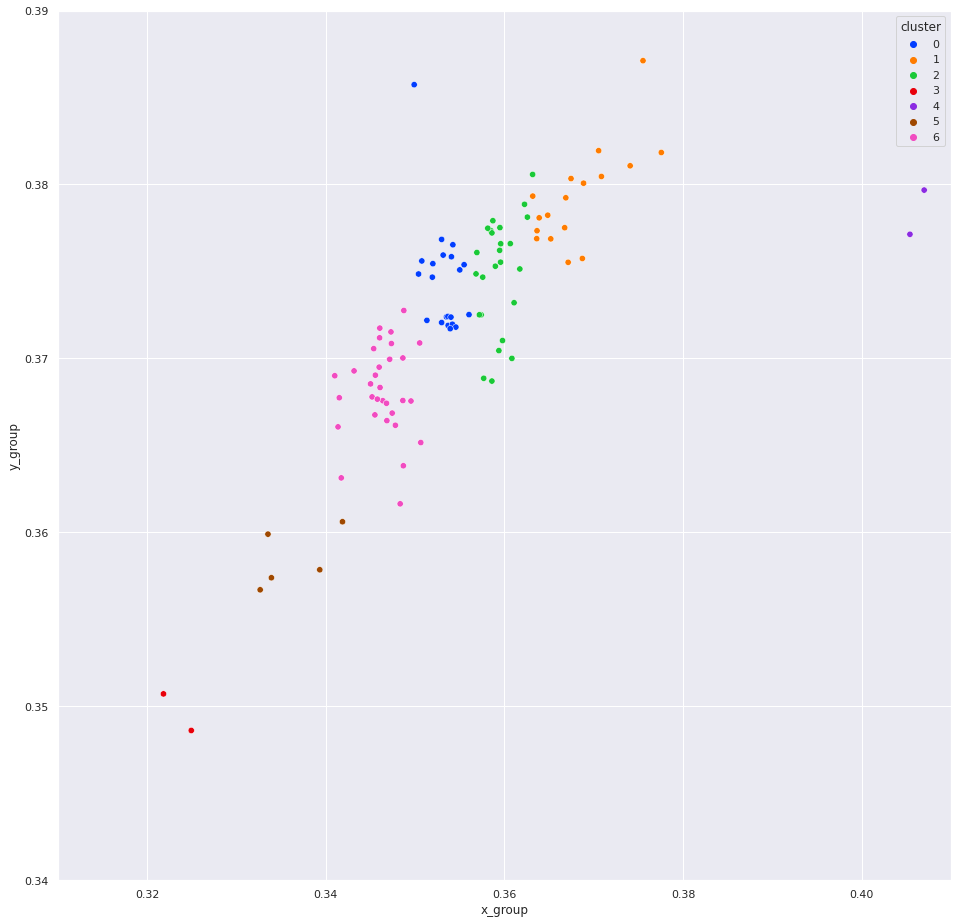

In [35]:
scatter(df, 'cluster', 'x_group', 'y_group', s=40, alpha=1, x_zoom=(0.31, 0.41), y_zoom=(0.34, 0.39))

In [36]:
from sklearn.cluster import KMeans
X = df[['x_group', 'y_group']]
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
kmeans.labels_
df['cluster_km'] = kmeans.predict(X)

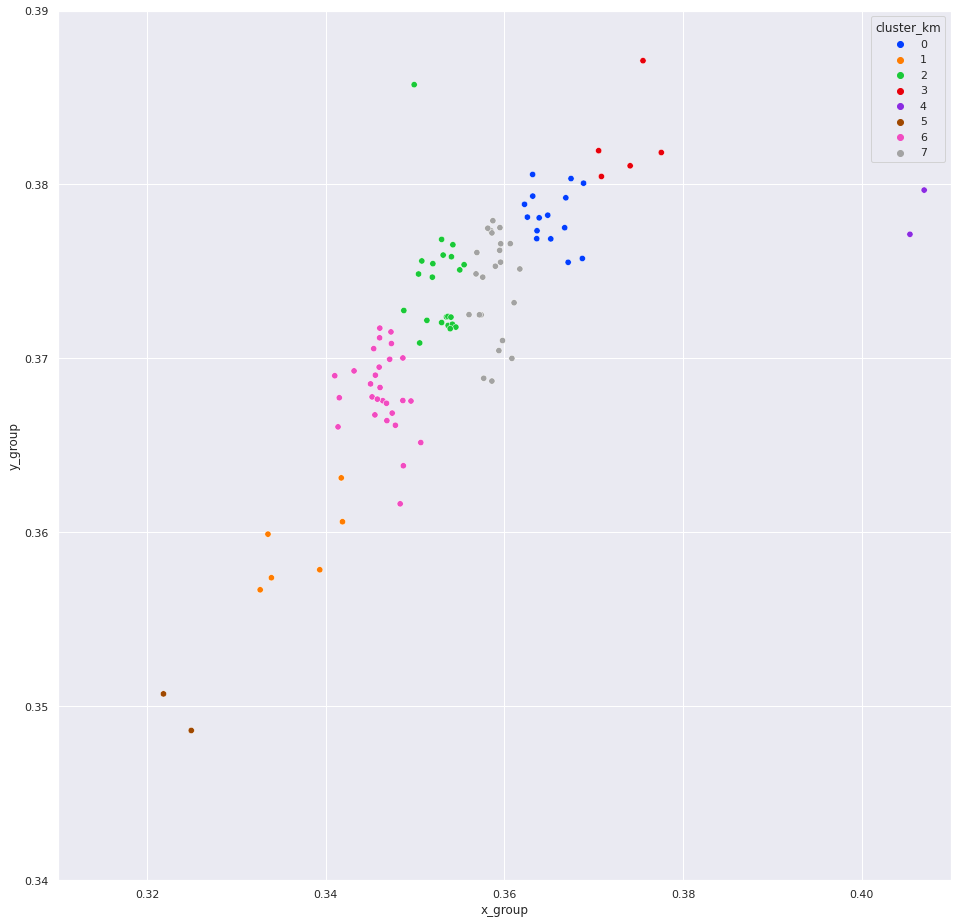

In [37]:
scatter(df, 'cluster_km', 'x_group', 'y_group', s=40, alpha=1, x_zoom=(0.31, 0.41), y_zoom=(0.34, 0.39))

In [38]:
kmeans.cluster_centers_

array([[0.36520581, 0.37818368],
       [0.33715344, 0.35926498],
       [0.35276166, 0.37429193],
       [0.37371261, 0.38248728],
       [0.40621172, 0.37840817],
       [0.32336137, 0.34966461],
       [0.34623989, 0.3680631 ],
       [0.35880666, 0.3742729 ]])

In [39]:
li_bins = [81, 3, 4, 5, 7, 9]
li_x = []
li_y = []
li_hex = []
li_idx = [i for i in range(len(kmeans.cluster_centers_))]
for x, y in kmeans.cluster_centers_:
    li_x.append(x)
    li_y.append(y)
    li_hex.append(cs.xy_to_rgb(x, y, out_fmt='html'))
data = {'centroid': li_idx, 'x_coord': li_x, 'y_coord': li_y, 'hex': li_hex}
df_centroids = pd.DataFrame(data=data)
for n in li_bins:
    col = 'bins_{}'.format(n)
    df_centroids[col] = df_centroids.apply(lambda x: bins(n, x.x_coord, x.y_coord), axis=1)

In [40]:
df_centroids

centroid   x_coord   y_coord      hex  \
0         0  0.365206  0.378184  #ffd382   
1         1  0.337153  0.359265  #fff1b6   
2         2  0.352762  0.374292  #ffe594   
3         3  0.373713  0.382487  #ffca75   
4         4  0.406212  0.378408  #ff9b58   
5         5  0.323361  0.349665  #faffd4   
6         6  0.346240  0.368063  #ffe9a2   
7         7  0.358807  0.374273  #ffda8c   

                                             bins_81  \
0  [1.0533888415596315e-05, 4.373258082886114e-05...   
1  [1.1746945301007799e-05, 4.877252534129922e-05...   
2  [1.0939297551632533e-05, 4.5417428909598656e-0...   
3  [1.0208296751482378e-05, 4.2379678324400415e-0...   
4  [9.569497227626309e-06, 3.972288029154458e-05,...   
5  [1.2352156770371513e-05, 5.128699431635611e-05...   
6  [1.1275291441247312e-05, 4.681320506598264e-05...   
7  [1.0798667754838747e-05, 4.4832714794600056e-0...   

                                              bins_3  \
0  [0.38249788049069994, 0.595199149093206, 0.022...   
1  [0.4208182656884472, 0.5584184726263381, 0.020...   
2  [0.39583264905866544, 0.5824702740210215, 0.02...   
3  [0.3720443204180515, 0.6052103583903513, 0.022...   
4  [0.34881527139182605, 0.6271011272984347, 0.02...   
5  [0.4399017950304471, 0.5400970616016363, 0.020...   
6  [0.40623195745528445, 0.572460295985865, 0.021...   
7  [0.3909097300507454, 0.5871315927582939, 0.021...   

                                              bins_4  \
0  [0.30734714573255806, 0.379337389770634, 0.310...   
1  [0.3433647340258087, 0.3643248521563928, 0.290...   
2  [0.31957571195351353, 0.37506557688773595, 0.3...   
3  [0.2976188751939189, 0.3831294217321484, 0.316...   
4  [0.2775467615629394, 0.3867291770042577, 0.333...   
5  [0.36132171897351983, 0.3567853756186702, 0.27...   
6  [0.3294740896535353, 0.37060419968810837, 0.29...   
7  [0.3152260756237872, 0.3761275912420796, 0.306...   

                                              bins_5  \
0  [0.22269327404729852, 0.25116605489149574, 0.4...   
1  [0.24931943064326192, 0.25846919596807777, 0.4...   
2  [0.2316704776667332, 0.2543882451093378, 0.424...   
3  [0.21552161517052743, 0.24895695989534242, 0.4...   
4  [0.20104606347084517, 0.2405972542905769, 0.45...   
5  [0.2625983805133347, 0.26206094049473627, 0.39...   
6  [0.2390134444847574, 0.2560932476558672, 0.417...   
7  [0.22851215623395515, 0.25283043758205304, 0.4...   

                                              bins_7  \
0  [0.0863833230843849, 0.25410885325272964, 0.18...   
1  [0.0966808349937109, 0.28222872508608204, 0.17...   
2  [0.08983964317845651, 0.26379842835533984, 0.1...   
3  [0.08361468180424747, 0.24646837991260398, 0.1...   
4  [0.07810623299732473, 0.2299749345956314, 0.18...   
5  [0.10181742543778813, 0.2962387542446949, 0.17...   
6  [0.09268582222112912, 0.27146842774299373, 0.1...   
7  [0.0886323422841739, 0.2602729501593353, 0.182...   

                                              bins_9  
0  [0.03454393716428471, 0.23250863033154595, 0.1...  
1  [0.03862426592329531, 0.26019215024098674, 0.1...  
2  [0.03591110762455735, 0.24187776139942604, 0.1...  
3  [0.03344763606800085, 0.22504089023129098, 0.1...  
4  [0.03127867064356971, 0.20978584210474896, 0.1...  
5  [0.040659767593092956, 0.27399607353356786, 0....  
6  [0.037039855810728405, 0.24949791814643074, 0....  
7  [0.03543488410519576, 0.23856177577700402, 0.1...

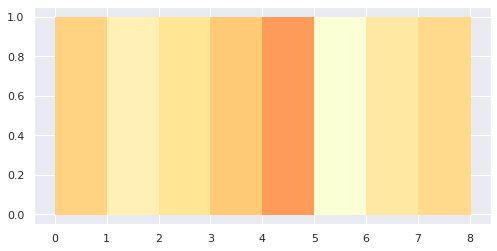

In [41]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(121)
ax.plot()
start = 0
colors = df_centroids.hex.to_list()
for color in colors:
    ax.add_patch(Rectangle((start, 0), 1, 1,color=color))
    start += 1
plt.show()

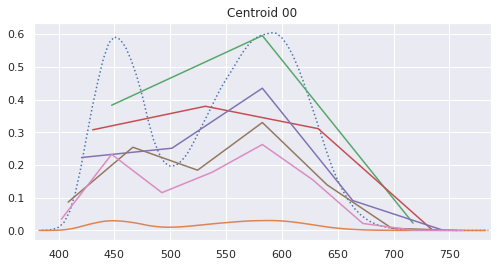

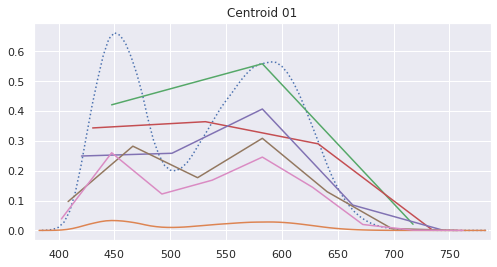

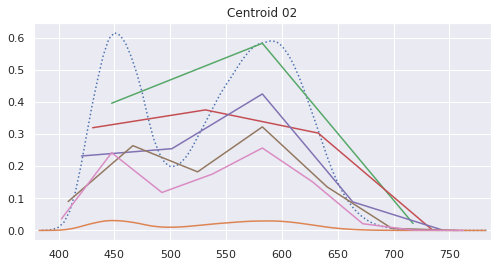

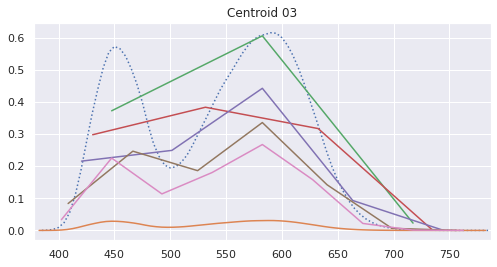

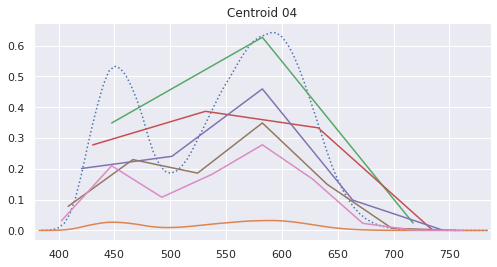

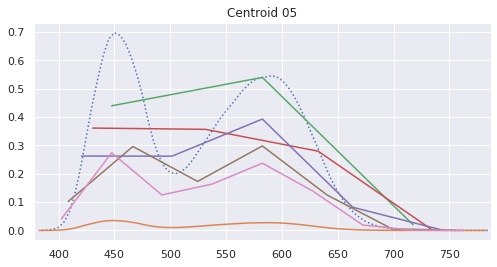

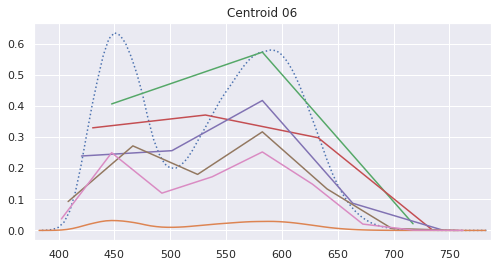

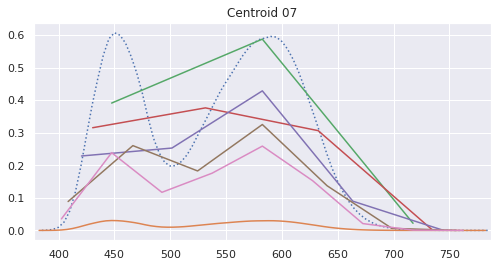

In [42]:
for centroid in list(df_centroids.centroid.unique()):
    title = 'Centroid {:02}'.format(centroid)
    fig = plt.figure(figsize=(18,4))
    ax = fig.add_subplot(121)
    ax.plot()
    col = 'bins_{}'.format(81)
    bins = df_centroids[df_centroids.centroid == centroid][col].to_list()[0]
    bins = [i*20 for i in bins]
    li_sample = np.linspace(min_opt, max_opt, len(bins) + 1, dtype=int)
    plt.plot(li_sample[1:], bins, linestyle='dotted')
    for n in li_bins:
        col = 'bins_{}'.format(n)
        bins = df_centroids[df_centroids.centroid == centroid][col].to_list()[0]
        li_sample = np.linspace(min_opt, max_opt, len(bins) + 1, dtype=int)
        offset = (li_sample[1]-li_sample[0]) / 2
        li_sample = [i - offset for i in li_sample]
        plt.plot(li_sample[1:], bins)
    plt.xlim([li_range[0]-2, li_range[-1]+2])
    plt.title(title)
    plt.show()    